#Load data

In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import math

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 40)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']
df['inc_angle'] = df_full['inc_angle']

Mounted at /content/drive


# Adding app

In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

import cv2 as cv
from google.colab.patches import cv2_imshow



# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve

from scipy.optimize import fmin, minimize_scalar

def show_bands(row):
  print(f'Index : {row.name}')
  f, (img1, img2) = plt.subplots(1, 2, figsize = (10,10))
  img1.imshow(np.array(row.band_1).reshape(75,75))
  img1.set_title("band_1")
  img2.imshow(np.array(row.band_2).reshape(75,75))
  img2.set_title("band_2")
  img1.set_yticks([])
  img1.set_xticks([])
  img2.set_yticks([])
  img2.set_xticks([])
  plt.show()

class EvaluateAndReport:
  def __init__(self, df, X_train, X_test, y_train, y_test, scoring = 'f1', grid_cv = 5, cv_cv = 10, best_scores_t = {}):
    self.df = df
    self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test
    self.scoring = scoring
    self.grid_cv = grid_cv
    self.cv_cv = cv_cv
    #self.threshold = threshold
    self.best_scores_t = best_scores_t


  def grid_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      print('--- Grid Search Report ---')
      grid_search = GridSearchCV(classifier, param_grid, cv = self.grid_cv, scoring = self.scoring, return_train_score = True)
      grid_search.fit(self.X_train, self.y_train)

      print(f'Best parameters for {classifier} :\n {grid_search.best_params_} with {self.scoring} score {round(grid_search.best_score_,3)}')

      self.last_best = grid_search.best_estimator_
    else:
      print("cross_report should be used when there is no param_grid")


  def cross_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Cross Validation Report ---')
    scorings = ('accuracy', 'f1', 'precision', 'recall')
    scores = cross_validate(classifier, self.X_train, self.y_train, cv = self.cv_cv, scoring = scorings)
    self.best_scores_t = {scoring : round(np.mean(scores["test_"+scoring]),3) for scoring in scorings}
    [print(f'Mean {scoring} score {round(np.mean(scores["test_"+scoring]),3)} with std {round(np.std(scores["test_"+scoring]),3)}') for scoring in scorings]


  def test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Test Sample Report ---')
    classifier.fit(self.X_train, self.y_train)
    self.last_y_pred = classifier.predict(self.X_test)

    print(f'Scores for the test sample :')
    print(f' accuracy : {round(accuracy_score(self.y_test, self.last_y_pred),3)}')
    print(f' f1 : {round(f1_score(self.y_test, self.last_y_pred),3)}')
    print(f' precision : {round(precision_score(self.y_test, self.last_y_pred),3)}')
    print(f' recall : {round(recall_score(self.y_test, self.last_y_pred),3)}')

    print('Confusion matrix for the test sample :')
    cm = confusion_matrix(self.y_test, self.last_y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Boat','Iceberg']).plot(cmap="Blues", values_format='')


  def grid_cross_test_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      self.grid_report(classifier, param_grid)
      self.cross_report(self.last_best)
      self.test_report(self.last_best)
    else:
      print('cross_test_report should be used when there is no param_grid')

  def cross_test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    self.cross_report(classifier)
    self.test_report(classifier)

  def cross_proba_report(self, classifier = None, threshold = 0.5):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Cross Validation with {threshold} Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, threshold))

  def calc_proba_scores(self, y_train_scores, threshold):
    y_pred = (y_train_scores >= threshold)
    return (accuracy_score(self.y_train, y_pred), f1_score(self.y_train, y_pred, zero_division=0), precision_score(self.y_train, y_pred, zero_division=0), recall_score(self.y_train, y_pred, zero_division=0))

  def print_proba_scores(self, scores):
    print(f' accuracy : {round(scores[0],3)}')
    print(f' f1 : {round(scores[1],3)}')
    print(f' precision : {round(scores[2],3)}')
    print(f' recall : {round(scores[3],3)}')

  def full_cross_proba_report(self, classifier = None, res = 50):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    probas = np.linspace(0.0,1.0,res)
    full_scores = np.array([self.calc_proba_scores(y_train_scores, threshold) for threshold in probas])

    plt.figure(figsize=(8,6))
    plt.plot(probas, full_scores[:,0], "b-", label="Accuracy", linewidth=2)
    plt.plot(probas, full_scores[:,1], "g-", label="F1", linewidth=2)
    plt.plot(probas, full_scores[:,2], "r-", label="Precision", linewidth=2)
    plt.plot(probas, full_scores[:,3], "c-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0.4, 1])
    plt.xlim([0, 1])
    plt.grid(b=True, linestyle='-')

    #Searching for optimals
    acc_opt = minimize_scalar(lambda x : -self.calc_proba_scores(y_train_scores, x)[0], bracket=(0.0,1.0))
    if acc_opt.x < 0: acc_opt.x = 0.0
    elif acc_opt.x > 1 : acc_opt.x = 1.0
    print(f'Optimal threshold for accuracy is {round(acc_opt.x,2)} with:')
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, acc_opt.x))

    acc_opt = minimize_scalar(lambda x : -self.calc_proba_scores(y_train_scores, x)[1], bracket=(0.0,1.0))
    if acc_opt.x < 0: acc_opt.x = 0.0
    elif acc_opt.x > 1 : acc_opt.x = 1.0
    print(f'Optimal threshold for f1 is {round(acc_opt.x,2)} with:')
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, acc_opt.x))

  def plot_precision_recall(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Precision Recall Curves ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    precisions, recalls, probas = precision_recall_curve(self.y_train, y_train_scores)

    plt.figure(0)
    plt.plot(probas, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(probas, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0, 1])

    plt.figure(1)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

  def plot_mistakes(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for wrongly predicted individuals
    #By default, false positives and false negatives are shown. If one is chosen in 'nature', the other ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boat_as_iceberg':
      print('--- Icebergs predicted as boats ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'iceberg_as_boat':
      print('--- Boats predicted as Icebergs ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)

  def plot_predicted(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for correclty predicted individuals
    #By default, correctly predicted icebergs and boats are shown. If one is chosen in 'nature', the others ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boats':
      print('--- Icebergs predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'icebergs':
      print('--- Boats predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)


# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['variance_b'+str(label)] = [np.var(np.array(matx)) for matx in data['band_'+str(label)]]



  #data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]

  return data


# Adding sobel features to the initial dataset

def add_sobel_features(datasobel, label, data) :
  #Find the contour pixels by taking out the max 75 elements
  
  datasobel['contourpixel_b'+str(label)] = [np.array(matx)[np.argpartition(np.array(matx), -75)[-75:]] for matx in datasobel['band_'+str(label)]]

  data['max_of_contour_b'+str(label)] = [np.max(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['min_of_contour_b'+str(label)] = [np.min(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['median_of_contour_b'+str(label)] = [np.median(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['mean_of_contour_b'+str(label)] = [np.mean(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmax_of_contour_b'+str(label)] = [np.argmax(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmin_of_contour_b'+str(label)] = [np.argmin(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['variance_of_contour_b'+str(label)] = [np.var(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]

  return data

def contour(matx):

  image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(matx), sigma_spatial = 1), weight = 0.1)
  image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
  
  image_8bit = np.array(np.uint8(image * 255))

  threshold_level = 155 # Set as we need...
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)
  #binarized= cv.adaptiveThreshold(image_8bit,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cv.drawContours(image, contours,-1,(0,255,0), 1)
  plt.imshow(image)
  cnt = contours[0]
  if cnt.size<10:
    cnt=contours[len(contours)-1]


  #Surace area of the contour
  area = cv.contourArea(cnt)

  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  if cnt.size>=10:
    ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
    A = np.pi * MA * ma/4
    ellipse_ratio=area/A
  else: 
    ellipse_ratio = "not_available"

  #Rectangle
  #Get Rec
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)
  box = np.int0(box)
  
  #Calculate Rec area
  a=math.sqrt((box[0][0]-box[1][0])**2+(box[0][1]-box[1][1])**2)
  b=math.sqrt((box[1][0]-box[2][0])**2+(box[1][1]-box[2][1])**2)
  Rec = a*b
  
  #Calculate Rec Ratio
  rec_ratio=area/Rec
  rec_ratio

  return area, perimeter, AP_Ratio, ellipse_ratio, rec_ratio


def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

def MatrixtoArray(data, label) :
  data['band_'+str(label)] = [np.array(matx).ravel() for matx in data['band_'+str(label)]]

# Plotting the new feature in a histogram
def plot_features(data, name):
  plt.hist(data.loc[data.is_iceberg==1,name], bins=50, color='navy',alpha=0.5,label='Iceberg')
  plt.hist(data.loc[data.is_iceberg==0,name], bins=50,color='firebrick',alpha=0.5, label='Bateau')
  plt.legend()
  plt.xlabel(name)
  #plt.ylabel('Frequency')
  plt.show()

# Loading the dataset and importing libraries


In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from numpy import fft
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Data treatment

In [ ]:
#df.head()

In [ ]:
#plt.imshow(df.iat[1,1])

## Image pretreatment example

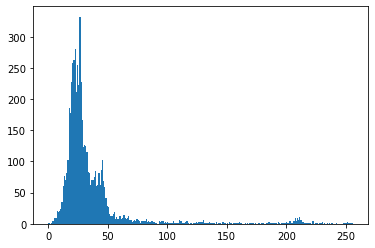

In [ ]:
from functools import partial
import pywt
from skimage import feature
from skimage.filters import sobel
import skimage as sk
import skimage.filters as fl
import skimage.restoration as rs
  
image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(df.iat[888,1]), sigma_spatial = 1), weight = 0.1)
image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
image_8bit = np.uint8(image * 255)
            
plt.hist(image_8bit.ravel(),bins = 256, range = [0, 256])
plt.show()

(170.5,
 75.35533833503723,
 2.2626134228465706,
 0.5963212652990765,
 [array([[[41, 23]],
  
         [[40, 24]],
  
         [[40, 25]],
  
         [[39, 26]],
  
         [[39, 27]],
  
         [[36, 30]],
  
         [[34, 30]],
  
         [[33, 31]],
  
         [[32, 31]],
  
         [[31, 32]],
  
         [[29, 32]],
  
         [[28, 33]],
  
         [[27, 33]],
  
         [[26, 34]],
  
         [[23, 34]],
  
         [[22, 35]],
  
         [[21, 35]],
  
         [[19, 37]],
  
         [[18, 37]],
  
         [[18, 39]],
  
         [[20, 41]],
  
         [[21, 40]],
  
         [[24, 40]],
  
         [[25, 39]],
  
         [[27, 39]],
  
         [[28, 38]],
  
         [[30, 38]],
  
         [[31, 37]],
  
         [[36, 37]],
  
         [[37, 38]],
  
         [[39, 38]],
  
         [[41, 36]],
  
         [[42, 36]],
  
         [[43, 35]],
  
         [[43, 31]],
  
         [[42, 30]],
  
         [[42, 25]],
  
         [[43, 24]],
  
         [[42, 23]

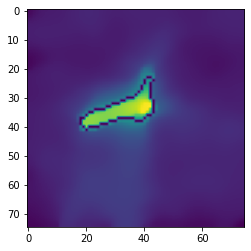

In [ ]:
  threshold_level = 127 #np.amax(image_8bit)/2 # Set as we need...
  
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)
  #binarized= cv.adaptiveThreshold(image_8bit,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cnt = contours[0]
  cv.drawContours(image, contours, -1, (0,255,0), 1)
  plt.imshow(image)
  cnt
  #threshold_level


  #Surace area of the contour
  area = cv.contourArea(cnt)
  
  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
  A = np.pi * MA * ma/4
  ellipse_ratio=area/A

  area, perimeter, AP_Ratio, ellipse_ratio, contours

##Add OpenCV contours

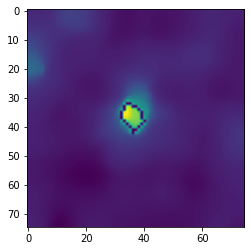

In [ ]:
df=apply_and_concat(df, 'band_1', contour, ['area1', 'perimeter1', 'AP_Ratio1', 'ellipse_ratio1','rec_ratio1'])
df=apply_and_concat(df, 'band_2', contour, ['area2', 'perimeter2', 'AP_Ratio2', 'ellipse_ratio2','rec_ratio2'])

##Denoise images

In [ ]:
#Denoise all images and draw the contour
def denoiseimg(x):
  y = np.array(x).reshape(75,75)
  y = (y - y.min())/(y.max()-y.min())
  y = rs.denoise_tv_chambolle(rs.denoise_bilateral(y.reshape(75,75), sigma_spatial = 1), weight = 0.1)
  y = y.ravel()
  return y

df["band_1"]=df["band_1"].apply(denoiseimg)
df["band_2"]=df["band_2"].apply(denoiseimg)

df.head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2
486,"[0.2859490966023374, 0.28461867993629886, 0.28...","[0.2738121087230967, 0.2733988688271165, 0.272...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556
760,"[0.2150496407224249, 0.21592598109175914, 0.21...","[0.22174586386139633, 0.22237613256708041, 0.2...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622
1502,"[0.3223078770878962, 0.3208062688624039, 0.318...","[0.45036190201696846, 0.4449595448097457, 0.43...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500
682,"[0.16522957250934434, 0.16741781237244205, 0.1...","[0.24124209739606542, 0.24279742092053774, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000
1324,"[0.3851571495575763, 0.38596087985417465, 0.38...","[0.39333380077484786, 0.39008893417101304, 0.3...",1,43.9204,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661


## Add general features

In [ ]:
# Adding all possible features 
df = add_features(df,1)
df = add_features(df,2)
df.head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2
486,"[0.2859490966023374, 0.28461867993629886, 0.28...","[0.2738121087230967, 0.2733988688271165, 0.272...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.763520,0.119434,0.262176,0.272043,3030,5563,0.003019,0.738811,0.159801,0.246106,0.254636,2955,5562,0.002476
760,"[0.2150496407224249, 0.21592598109175914, 0.21...","[0.22174586386139633, 0.22237613256708041, 0.2...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.809186,0.187993,0.249596,0.258900,2739,5559,0.003081,0.785444,0.170017,0.231828,0.241830,2739,5559,0.002865
1502,"[0.3223078770878962, 0.3208062688624039, 0.318...","[0.45036190201696846, 0.4449595448097457, 0.43...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.803208,0.226509,0.366340,0.377665,2358,5175,0.003292,0.763137,0.265816,0.462308,0.466680,2357,4198,0.002393
682,"[0.16522957250934434, 0.16741781237244205, 0.1...","[0.24124209739606542, 0.24279742092053774, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.738047,0.141814,0.205832,0.211124,2737,5565,0.001810,0.717693,0.171885,0.264332,0.269507,2662,1800,0.001368
1324,"[0.3851571495575763, 0.38596087985417465, 0.38...","[0.39333380077484786, 0.39008893417101304, 0.3...",1,43.9204,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661,0.780720,0.236529,0.366813,0.370002,2587,5250,0.001265,0.766059,0.193349,0.386247,0.388320,2587,5616,0.001178


##Add Sobel Contour Features

In [ ]:
# Adding sobel contour features 
df_sobel = pd.DataFrame(columns=['band_1','band_2'])

def sobelimg(x):
  y = np.array(x).reshape(75,75)
  y = sobel(y)
  y = y.ravel()
  return y

df_sobel["band_1"]=df["band_1"].apply(sobelimg)
df_sobel["band_2"]=df["band_2"].apply(sobelimg)


df = add_sobel_features(df_sobel,1,df)
df = add_sobel_features(df_sobel,2,df)
df.head()



,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,argmin_of_contour_b2,variance_of_contour_b2
486,"[0.2859490966023374, 0.28461867993629886, 0.28...","[0.2738121087230967, 0.2733988688271165, 0.272...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.763520,0.119434,0.262176,0.272043,3030,5563,0.003019,0.738811,0.159801,0.246106,0.254636,2955,5562,0.002476,0.273977,0.130744,0.180378,0.190231,70,0,0.001374,0.274700,0.119725,0.167851,0.177147,71,0,0.001737
760,"[0.2150496407224249, 0.21592598109175914, 0.21...","[0.22174586386139633, 0.22237613256708041, 0.2...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.809186,0.187993,0.249596,0.258900,2739,5559,0.003081,0.785444,0.170017,0.231828,0.241830,2739,5559,0.002865,0.257232,0.097203,0.142007,0.149770,61,0,0.001690,0.286285,0.101574,0.137578,0.162455,47,0,0.002795
1502,"[0.3223078770878962, 0.3208062688624039, 0.318...","[0.45036190201696846, 0.4449595448097457, 0.43...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.803208,0.226509,0.366340,0.377665,2358,5175,0.003292,0.763137,0.265816,0.462308,0.466680,2357,4198,0.002393,0.207015,0.066357,0.111964,0.113293,67,0,0.001388,0.116685,0.060460,0.074668,0.078985,71,0,0.000197
682,"[0.16522957250934434, 0.16741781237244205, 0.1...","[0.24124209739606542, 0.24279742092053774, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.738047,0.141814,0.205832,0.211124,2737,5565,0.001810,0.717693,0.171885,0.264332,0.269507,2662,1800,0.001368,0.282850,0.088742,0.134164,0.154729,65,0,0.003109,0.229686,0.067874,0.116616,0.124866,49,0,0.002120
1324,"[0.3851571495575763, 0.38596087985417465, 0.38...","[0.39333380077484786, 0.39008893417101304, 0.3...",1,43.9204,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661,0.780720,0.236529,0.366813,0.370002,2587,5250,0.001265,0.766059,0.193349,0.386247,0.388320,2587,5616,0.001178,0.254984,0.074531,0.110046,0.133584,74,0,0.003287,0.232614,0.074469,0.105407,0.122728,45,0,0.002296


##Split all the pixels into a table called X

In [ ]:
naive_base_pretreated = X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

In [ ]:
X

,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,band_1_35,band_1_36,band_1_37,band_1_38,band_1_39,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
486,0.285949,0.284619,0.281471,0.275435,0.268908,0.267516,0.266628,0.266271,0.266285,0.266647,0.267331,0.268462,0.269404,0.269069,0.267237,0.262557,0.253413,0.243527,0.238430,0.236574,0.236523,0.238377,0.241214,0.243179,0.244110,0.243858,0.243412,0.244062,0.245420,0.248810,0.250065,0.249824,0.248962,0.248585,0.249542,0.252389,0.254434,0.255664,0.256594,0.257697,...,0.198636,0.190863,0.188378,0.185827,0.183523,0.180913,0.176214,0.173937,0.174109,0.239433,0.246647,0.250383,0.253471,0.255478,0.256958,0.263509,0.280899,0.289034,0.296240,0.301120,0.303202,0.303482,0.302142,0.298367,0.289398,0.280755,0.268755,0.244416,0.229861,0.229044,0.228515,0.228845,0.231666,0.234789,0.239122,0.242721,0.245271,0.247499,0.248710,0.249314
760,0.215050,0.215926,0.217425,0.218969,0.220584,0.222458,0.223861,0.224886,0.228089,0.229835,0.230600,0.231205,0.231463,0.232007,0.232581,0.233466,0.234824,0.236740,0.238761,0.240762,0.242364,0.243521,0.244205,0.244557,0.244648,0.244493,0.244329,0.244385,0.244883,0.245993,0.247737,0.249705,0.251294,0.251918,0.251790,0.251148,0.249595,0.246794,0.243849,0.241144,...,0.211725,0.210976,0.210251,0.208970,0.208839,0.209877,0.211534,0.217426,0.220322,0.221274,0.221207,0.219826,0.216109,0.210142,0.203481,0.199260,0.198850,0.199342,0.199855,0.201674,0.205256,0.207925,0.210281,0.213212,0.214671,0.215546,0.216264,0.216256,0.215017,0.213417,0.212247,0.211208,0.210056,0.209012,0.208139,0.207572,0.207519,0.207614,0.207606,0.207631
1502,0.322308,0.320806,0.318666,0.317717,0.318966,0.324059,0.337254,0.351522,0.364716,0.374960,0.379913,0.381216,0.380837,0.379095,0.375631,0.370348,0.362990,0.356314,0.351180,0.346329,0.342825,0.346009,0.352638,0.358764,0.361730,0.362021,0.360128,0.355923,0.350753,0.345042,0.339071,0.335915,0.337218,0.337584,0.337438,0.336796,0.335089,0.333477,0.332057,0.331401,...,0.433514,0.433407,0.430080,0.426560,0.356195,0.439169,0.458268,0.470167,0.491221,0.494352,0.493314,0.489235,0.474528,0.463556,0.433744,0.464141,0.485078,0.491821,0.496047,0.497103,0.495542,0.490977,0.488278,0.486288,0.485664,0.484668,0.484105,0.481238,0.477031,0.471918,0.466716,0.462680,0.461033,0.459536,0.458650,0.457714,0.458152,0.459428,0.461731,0.464367
682,0.165230,0.167418,0.171763,0.176643,0.181891,0.186912,0.193669,0.198160,0.200373,0.201120,0.200921,0.199591,0.197993,0.195977,0.193959,0.192833,0.192264,0.192221,0.192189,0.192539,0.192750,0.193288,0.193936,0.194571,0.195025,0.195397,0.196006,0.197174,0.199451,0.202781,0.206650,0.213131,0.221208,0.228368,0.234164,0.238919,0.242153,0.242904,0.242273,0.240243,...,0.245192,0.245579,0.246471,0.249898,0.254184,0.262515,0.272227,0.275718,0.279228,0.280827,0.280530,0.278108,0.272877,0.261872,0.250081,0.246742,0.244695,0.243878,0.245646,0.248471,0.251321,0.253861,0.255019,0.255403,0.255000,0.253022,0.253503,0.254744,0.257576,0.261282,0.263152,0.263732,0.263377,0.261498,0.258326,0.255753,0.251475,0.239992,0.239261,0.239018
1324,0.385157,0.385961,0.385967,0.394907,0.396300,0.394814,0.390081,0.384616,0.380663,0.377223,0.375044,0.373522,0.372603,0.371610,0.370522,0.369416,0.367956,0.366267,0.363851,0.350875,0.341083,0.336272,0.332459,

##Join the split pixels with images and features

In [ ]:
# splitting the bands into single elements
df = df.join(naive_base_pretreated)

In [ ]:
df.head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
486,"[0.2859490966023374, 0.28461867993629886, 0.28...","[0.2738121087230967, 0.2733988688271165, 0.272...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.763520,0.119434,0.262176,0.272043,3030,5563,0.003019,0.738811,0.159801,0.246106,0.254636,2955,5562,0.002476,0.273977,0.130744,0.180378,0.190231,70,0,0.001374,0.274700,0.119725,0.167851,0.177147,71,...,0.198636,0.190863,0.188378,0.185827,0.183523,0.180913,0.176214,0.173937,0.174109,0.239433,0.246647,0.250383,0.253471,0.255478,0.256958,0.263509,0.280899,0.289034,0.296240,0.301120,0.303202,0.303482,0.302142,0.298367,0.289398,0.280755,0.268755,0.244416,0.229861,0.229044,0.228515,0.228845,0.231666,0.234789,0.239122,0.242721,0.245271,0.247499,0.248710,0.249314
760,"[0.2150496407224249, 0.21592598109175914, 0.21...","[0.22174586386139633, 0.22237613256708041, 0.2...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.809186,0.187993,0.249596,0.258900,2739,5559,0.003081,0.785444,0.170017,0.231828,0.241830,2739,5559,0.002865,0.257232,0.097203,0.142007,0.149770,61,0,0.001690,0.286285,0.101574,0.137578,0.162455,47,...,0.211725,0.210976,0.210251,0.208970,0.208839,0.209877,0.211534,0.217426,0.220322,0.221274,0.221207,0.219826,0.216109,0.210142,0.203481,0.199260,0.198850,0.199342,0.199855,0.201674,0.205256,0.207925,0.210281,0.213212,0.214671,0.215546,0.216264,0.216256,0.215017,0.213417,0.212247,0.211208,0.210056,0.209012,0.208139,0.207572,0.207519,0.207614,0.207606,0.207631
1502,"[0.3223078770878962, 0.3208062688624039, 0.318...","[0.45036190201696846, 0.4449595448097457, 0.43...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.803208,0.226509,0.366340,0.377665,2358,5175,0.003292,0.763137,0.265816,0.462308,0.466680,2357,4198,0.002393,0.207015,0.066357,0.111964,0.113293,67,0,0.001388,0.116685,0.060460,0.074668,0.078985,71,...,0.433514,0.433407,0.430080,0.426560,0.356195,0.439169,0.458268,0.470167,0.491221,0.494352,0.493314,0.489235,0.474528,0.463556,0.433744,0.464141,0.485078,0.491821,0.496047,0.497103,0.495542,0.490977,0.488278,0.486288,0.485664,0.484668,0.484105,0.481238,0.477031,0.471918,0.466716,0.462680,0.461033,0.459536,0.458650,0.457714,0.458152,0.459428,0.461731,0.464367
682,"[0.16522957250934434, 0.16741781237244205, 0.1...","[0.24124209739606542, 0.24279742092053774, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.738047,0.141814,0.205832,0.211124,2737,5565,0.001810,0.717693,0.171885,0.264332,0.269507,2662,1800,0.001368,0.282850,0.088742,0.134164,0.154729,65,0,0.003109,0.229686,0.067874,0.116616,0.124866,49,...,0.245192,0.245579,0.246471,0.249898,0.254184,0.262515,0.272227,0.275718,0.279228,0.280827,0.280530,0.278108,0.272877,0.261872,0.250081,0.246742,0.244695,0.243878,0.245646,0.248471,0.251321,0.253861,0.255019,0.255403,0.255000,0.253022,0.253503,0.254744,0.257576,0.261282,0.263152,0.263732,0.263377,0.261498,

In [ ]:
df["band_1"][824]

array([0.17829118, 0.18025075, 0.18564069, ..., 0.11682832, 0.11151332,
       0.10953672])

## Histograms of features

In [ ]:
#There are 13 images where there are fewer than 4 points on the contour therefore not possible to draw an ellipse

df[(df["ellipse_ratio1"]=='not_available') | (df["ellipse_ratio2"]=='not_available')]

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
1270,"[0.48897593983187443, 0.4879313850500822, 0.48...","[0.4995533543603657, 0.498634988550025, 0.4970...",1,37.2802,6.0,10.828427,0.554097,not_available,0.750000,11.0,14.828427,0.741818,0.72866,0.733333,0.684088,0.250380,0.373191,0.374090,2882,5578,0.001120,0.691100,0.203218,0.405896,0.405602,2882,5025,0.000983,0.216750,0.035733,0.050218,0.074051,54,0,0.002399,0.181919,0.039568,0.074419,0.082731,59,...,0.332066,0.328669,0.324882,0.324239,0.324514,0.325617,0.327208,0.327915,0.328485,0.329807,0.332383,0.336912,0.349451,0.359146,0.368429,0.377468,0.386117,0.391534,0.396045,0.399911,0.402938,0.406739,0.409883,0.412894,0.417410,0.422025,0.425174,0.426774,0.427145,0.426601,0.425397,0.424236,0.422937,0.421068,0.417700,0.413726,0.409227,0.402360,0.376087,0.327376
1445,"[0.3453374220731933, 0.34840025700790384, 0.35...","[0.4615384876013876, 0.46227310007845457, 0.46...",1,34.4709,80.5,39.556349,2.035072,0.786243,0.670833,1.0,4.828427,0.207107,not_available,0.316228,0.802209,0.253000,0.400534,0.406560,2811,901,0.003202,0.812573,0.216306,0.494884,0.499976,2810,12,0.002182,0.164806,0.078716,0.106249,0.111127,69,0,0.000529,0.163228,0.066596,0.089071,0.096788,20,...,0.531229,0.540822,0.547554,0.550246,0.551092,0.550627,0.548613,0.545868,0.542673,0.538292,0.532676,0.527301,0.522107,0.518330,0.515382,0.513239,0.511234,0.509227,0.507233,0.505205,0.503380,0.501404,0.498427,0.493948,0.491565,0.490085,0.489211,0.489286,0.490261,0.491871,0.494017,0.495678,0.496919,0.497541,0.497613,0.497123,0.495900,0.493982,0.491598,0.489590
1183,"[0.3845483506524973, 0.3852749147763668, 0.385...","[0.4159039434953931, 0.4164329656101807, 0.416...",1,34.8498,4.0,8.000000,0.500000,not_available,1.000000,15.0,17.656854,0.849528,0.516406,0.714286,0.683930,0.182434,0.348955,0.349405,2888,5325,0.000540,0.678097,0.241387,0.418300,0.419069,2888,5250,0.000457,0.214663,0.024719,0.043350,0.077849,64,0,0.003732,0.163456,0.028553,0.049355,0.066148,52,...,0.430226,0.422642,0.419016,0.416832,0.415044,0.413690,0.412560,0.410895,0.408389,0.406256,0.404499,0.402169,0.400538,0.399965,0.400316,0.402009,0.406550,0.415054,0.428777,0.434086,0.438334,0.440285,0.440013,0.437147,0.432324,0.423602,0.413839,0.402299,0.393887,0.388385,0.385395,0.383402,0.382711,0.382358,0.381132,0.378551,0.373581,0.365844,0.364232,0.363567
9,"[0.22695672259230573, 0.2286278938537659, 0.23...","[0.2745936000247324, 0.2756545755220558, 0.279...",0,43.3007,7.0,10.828427,0.646447,0.652643,0.777778,4.0,8.000000,0.500000,not_available,1.000000,0.758944,0.223071,0.285934,0.285357,2811,4875,0.000610,0.762664,0.257040,0.326907,0.327127,2811,377,0.000501,0.320258,0.019149,0.063771,0.106718,41,0,0.009348,0.285295,0.017574,0.039111,0.090732,73,...,0.328397,0.329557,0.332563,0.336718,0.341982,0.347027,0.350798,0.352220,0.352570,0.351952,0.349761,0.345514,0.343317,0.342566,0.342228,0.342218,0.342462,0.342420,0.341667,0.340335,0.337927,0.334060,0.328930,0.322835,0.320707,0.319997,0.319691,0.319919,0.320254,0.320137,0.318920,0.316300,0.311891,0.3

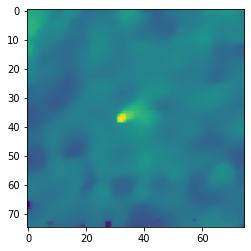

In [ ]:
example=np.array(df.loc[[1270],'band_2'])
plt.imshow(example[0].reshape(75,75))

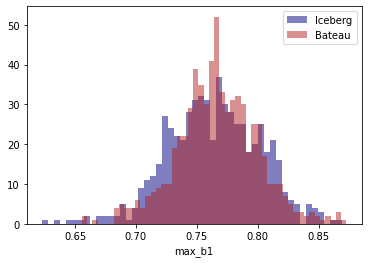

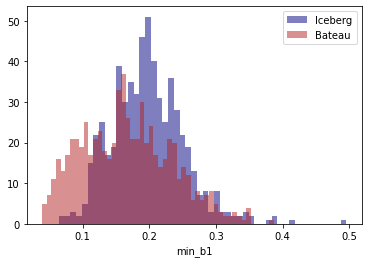

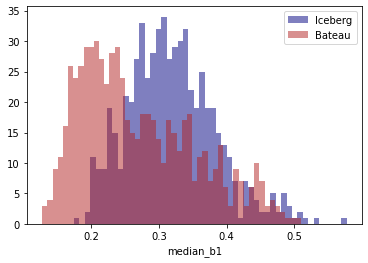

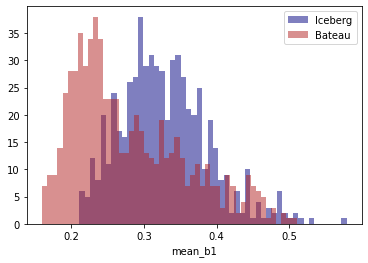

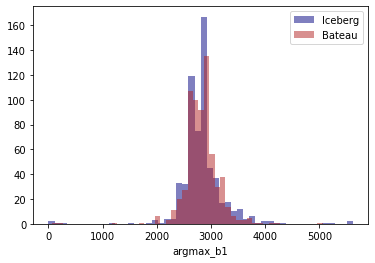

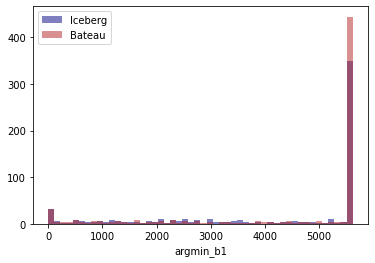

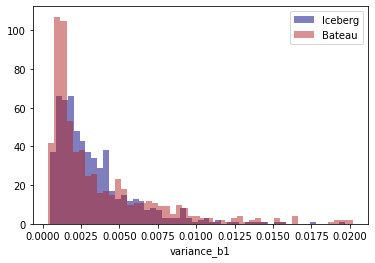

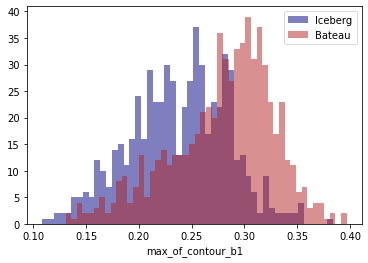

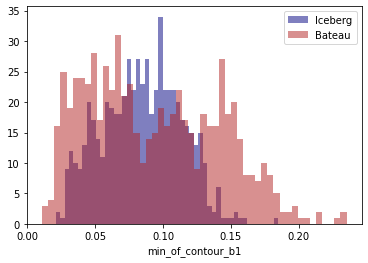

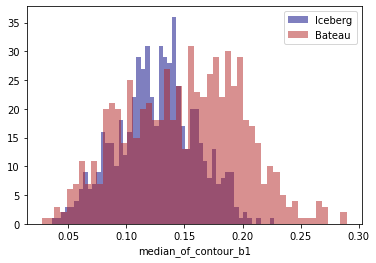

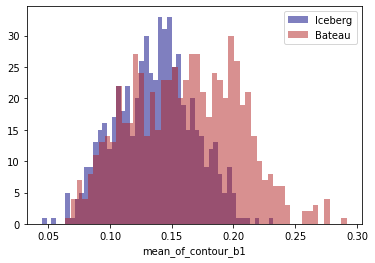

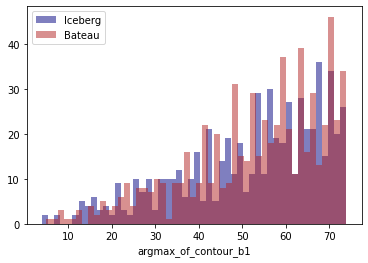

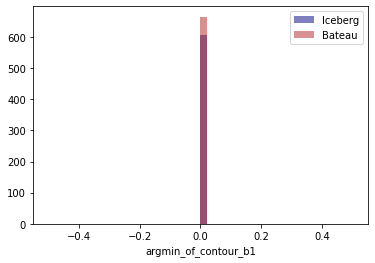

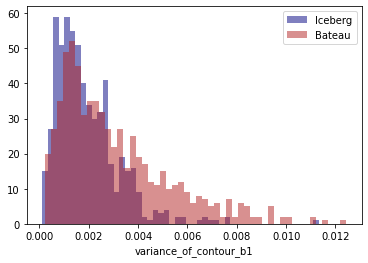

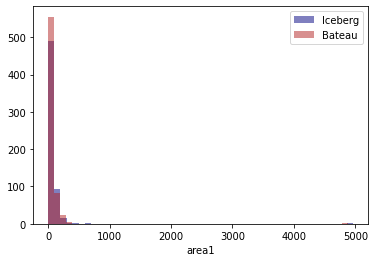

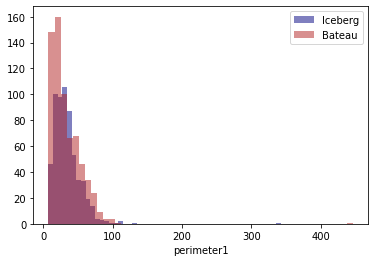

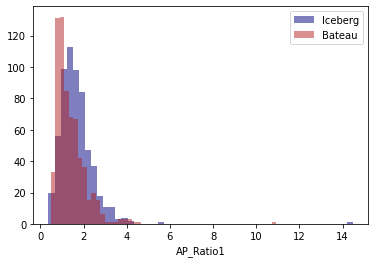

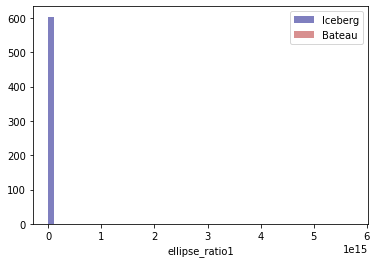

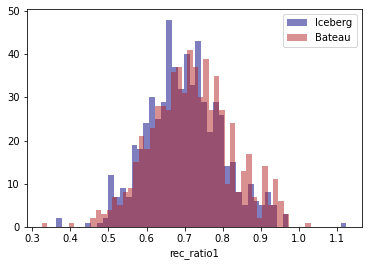

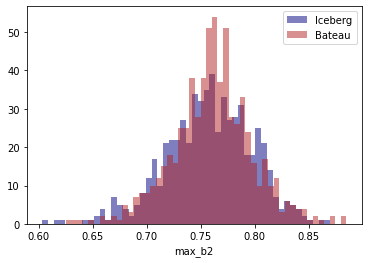

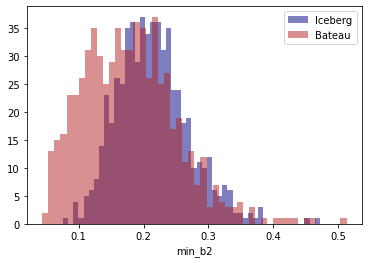

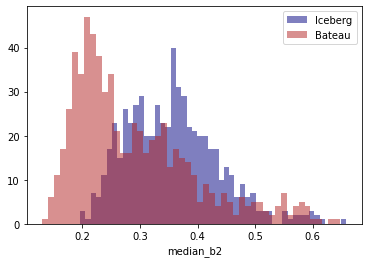

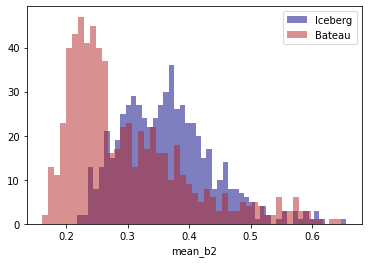

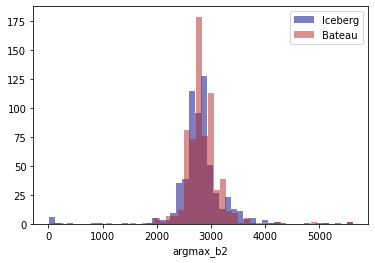

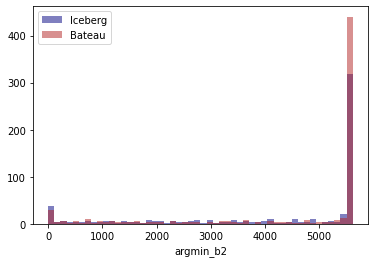

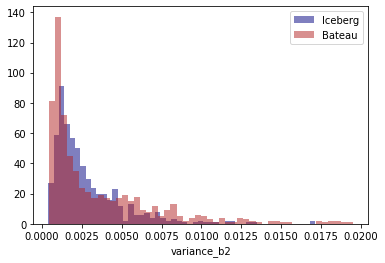

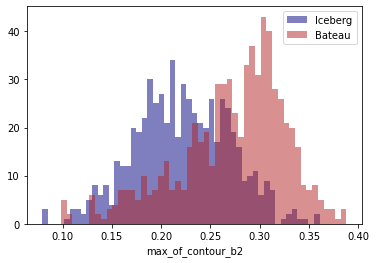

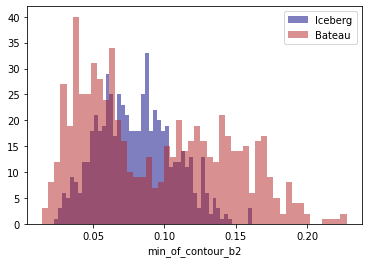

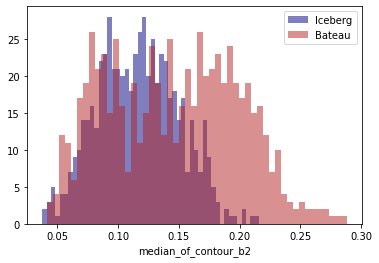

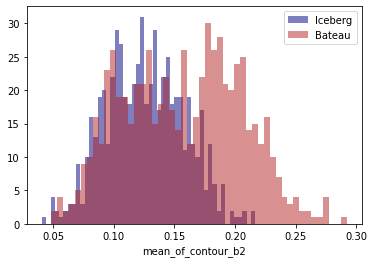

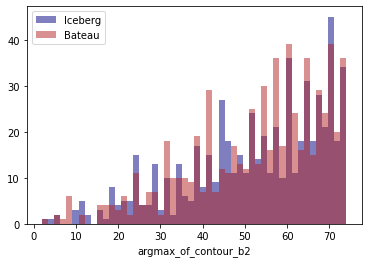

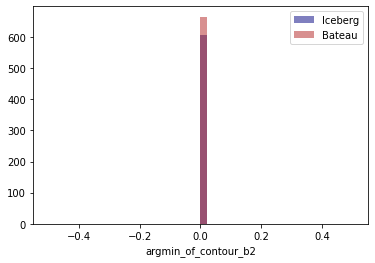

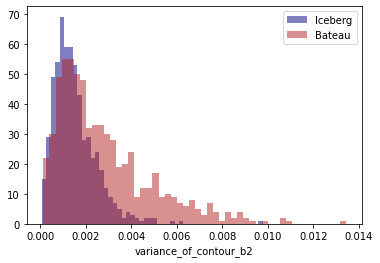

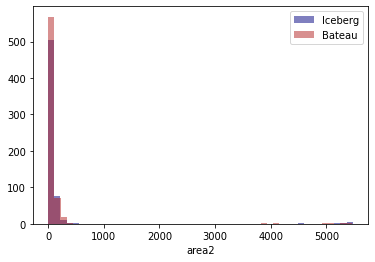

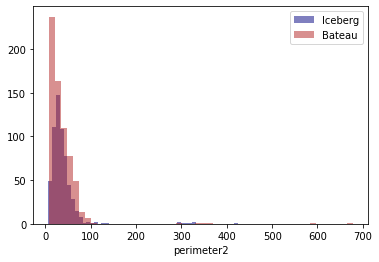

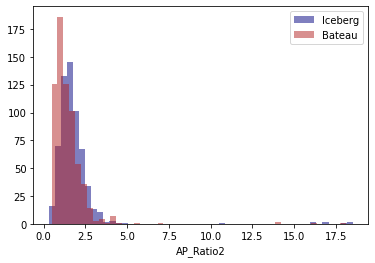

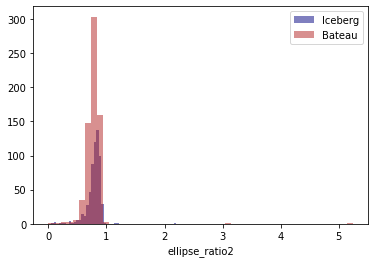

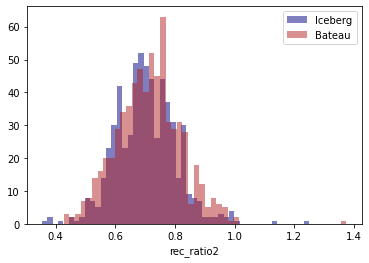

In [ ]:
# plotting the variables
for i in [1,2] :
  
  for col in ['max_b'+str(i),'min_b'+str(i),'median_b'+str(i),'mean_b'+str(i),'argmax_b'+str(i),'argmin_b'+str(i),'variance_b'+str(i),
              
              'max_of_contour_b'+str(i),'min_of_contour_b'+str(i),'median_of_contour_b'+str(i),'mean_of_contour_b'+str(i),

              'argmax_of_contour_b'+str(i),'argmin_of_contour_b'+str(i),'variance_of_contour_b'+str(i),

              'area'+str(i),'perimeter'+str(i),'AP_Ratio'+str(i),'ellipse_ratio'+str(i),'rec_ratio'+str(i)]:  

    plot_features(df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')],col)

## Matrice de corrélation

In [ ]:
df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
486,"[0.2859490966023374, 0.28461867993629886, 0.28...","[0.2738121087230967, 0.2733988688271165, 0.272...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.763520,0.119434,0.262176,0.272043,3030,5563,0.003019,0.738811,0.159801,0.246106,0.254636,2955,5562,0.002476,0.273977,0.130744,0.180378,0.190231,70,0,0.001374,0.274700,0.119725,0.167851,0.177147,71,...,0.198636,0.190863,0.188378,0.185827,0.183523,0.180913,0.176214,0.173937,0.174109,0.239433,0.246647,0.250383,0.253471,0.255478,0.256958,0.263509,0.280899,0.289034,0.296240,0.301120,0.303202,0.303482,0.302142,0.298367,0.289398,0.280755,0.268755,0.244416,0.229861,0.229044,0.228515,0.228845,0.231666,0.234789,0.239122,0.242721,0.245271,0.247499,0.248710,0.249314
760,"[0.2150496407224249, 0.21592598109175914, 0.21...","[0.22174586386139633, 0.22237613256708041, 0.2...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.809186,0.187993,0.249596,0.258900,2739,5559,0.003081,0.785444,0.170017,0.231828,0.241830,2739,5559,0.002865,0.257232,0.097203,0.142007,0.149770,61,0,0.001690,0.286285,0.101574,0.137578,0.162455,47,...,0.211725,0.210976,0.210251,0.208970,0.208839,0.209877,0.211534,0.217426,0.220322,0.221274,0.221207,0.219826,0.216109,0.210142,0.203481,0.199260,0.198850,0.199342,0.199855,0.201674,0.205256,0.207925,0.210281,0.213212,0.214671,0.215546,0.216264,0.216256,0.215017,0.213417,0.212247,0.211208,0.210056,0.209012,0.208139,0.207572,0.207519,0.207614,0.207606,0.207631
1502,"[0.3223078770878962, 0.3208062688624039, 0.318...","[0.45036190201696846, 0.4449595448097457, 0.43...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.803208,0.226509,0.366340,0.377665,2358,5175,0.003292,0.763137,0.265816,0.462308,0.466680,2357,4198,0.002393,0.207015,0.066357,0.111964,0.113293,67,0,0.001388,0.116685,0.060460,0.074668,0.078985,71,...,0.433514,0.433407,0.430080,0.426560,0.356195,0.439169,0.458268,0.470167,0.491221,0.494352,0.493314,0.489235,0.474528,0.463556,0.433744,0.464141,0.485078,0.491821,0.496047,0.497103,0.495542,0.490977,0.488278,0.486288,0.485664,0.484668,0.484105,0.481238,0.477031,0.471918,0.466716,0.462680,0.461033,0.459536,0.458650,0.457714,0.458152,0.459428,0.461731,0.464367
682,"[0.16522957250934434, 0.16741781237244205, 0.1...","[0.24124209739606542, 0.24279742092053774, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.738047,0.141814,0.205832,0.211124,2737,5565,0.001810,0.717693,0.171885,0.264332,0.269507,2662,1800,0.001368,0.282850,0.088742,0.134164,0.154729,65,0,0.003109,0.229686,0.067874,0.116616,0.124866,49,...,0.245192,0.245579,0.246471,0.249898,0.254184,0.262515,0.272227,0.275718,0.279228,0.280827,0.280530,0.278108,0.272877,0.261872,0.250081,0.246742,0.244695,0.243878,0.245646,0.248471,0.251321,0.253861,0.255019,0.255403,0.255000,0.253022,0.253503,0.254744,0.257576,0.261282,0.263152,0.263732,0.263377,0.261498,

In [ ]:
df["ellipse_ratio1"]=pd.to_numeric(df["ellipse_ratio1"],errors = 'coerce')
df["ellipse_ratio2"]=pd.to_numeric(df["ellipse_ratio2"],errors = 'coerce')

In [ ]:
df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 486 to 791
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   band_1                  1283 non-null   object 
 1   band_2                  1283 non-null   object 
 2   is_iceberg              1283 non-null   int64  
 3   inc_angle               1189 non-null   float64
 4   area1                   1283 non-null   float64
 5   perimeter1              1283 non-null   float64
 6   AP_Ratio1               1283 non-null   float64
 7   ellipse_ratio1          1278 non-null   float64
 8   rec_ratio1              1283 non-null   float64
 9   area2                   1283 non-null   float64
 10  perimeter2              1283 non-null   float64
 11  AP_Ratio2               1283 non-null   float64
 12  ellipse_ratio2          1274 non-null   float64
 13  rec_ratio2              1283 non-null   float64
 14  max_b1                  1283 non-null  

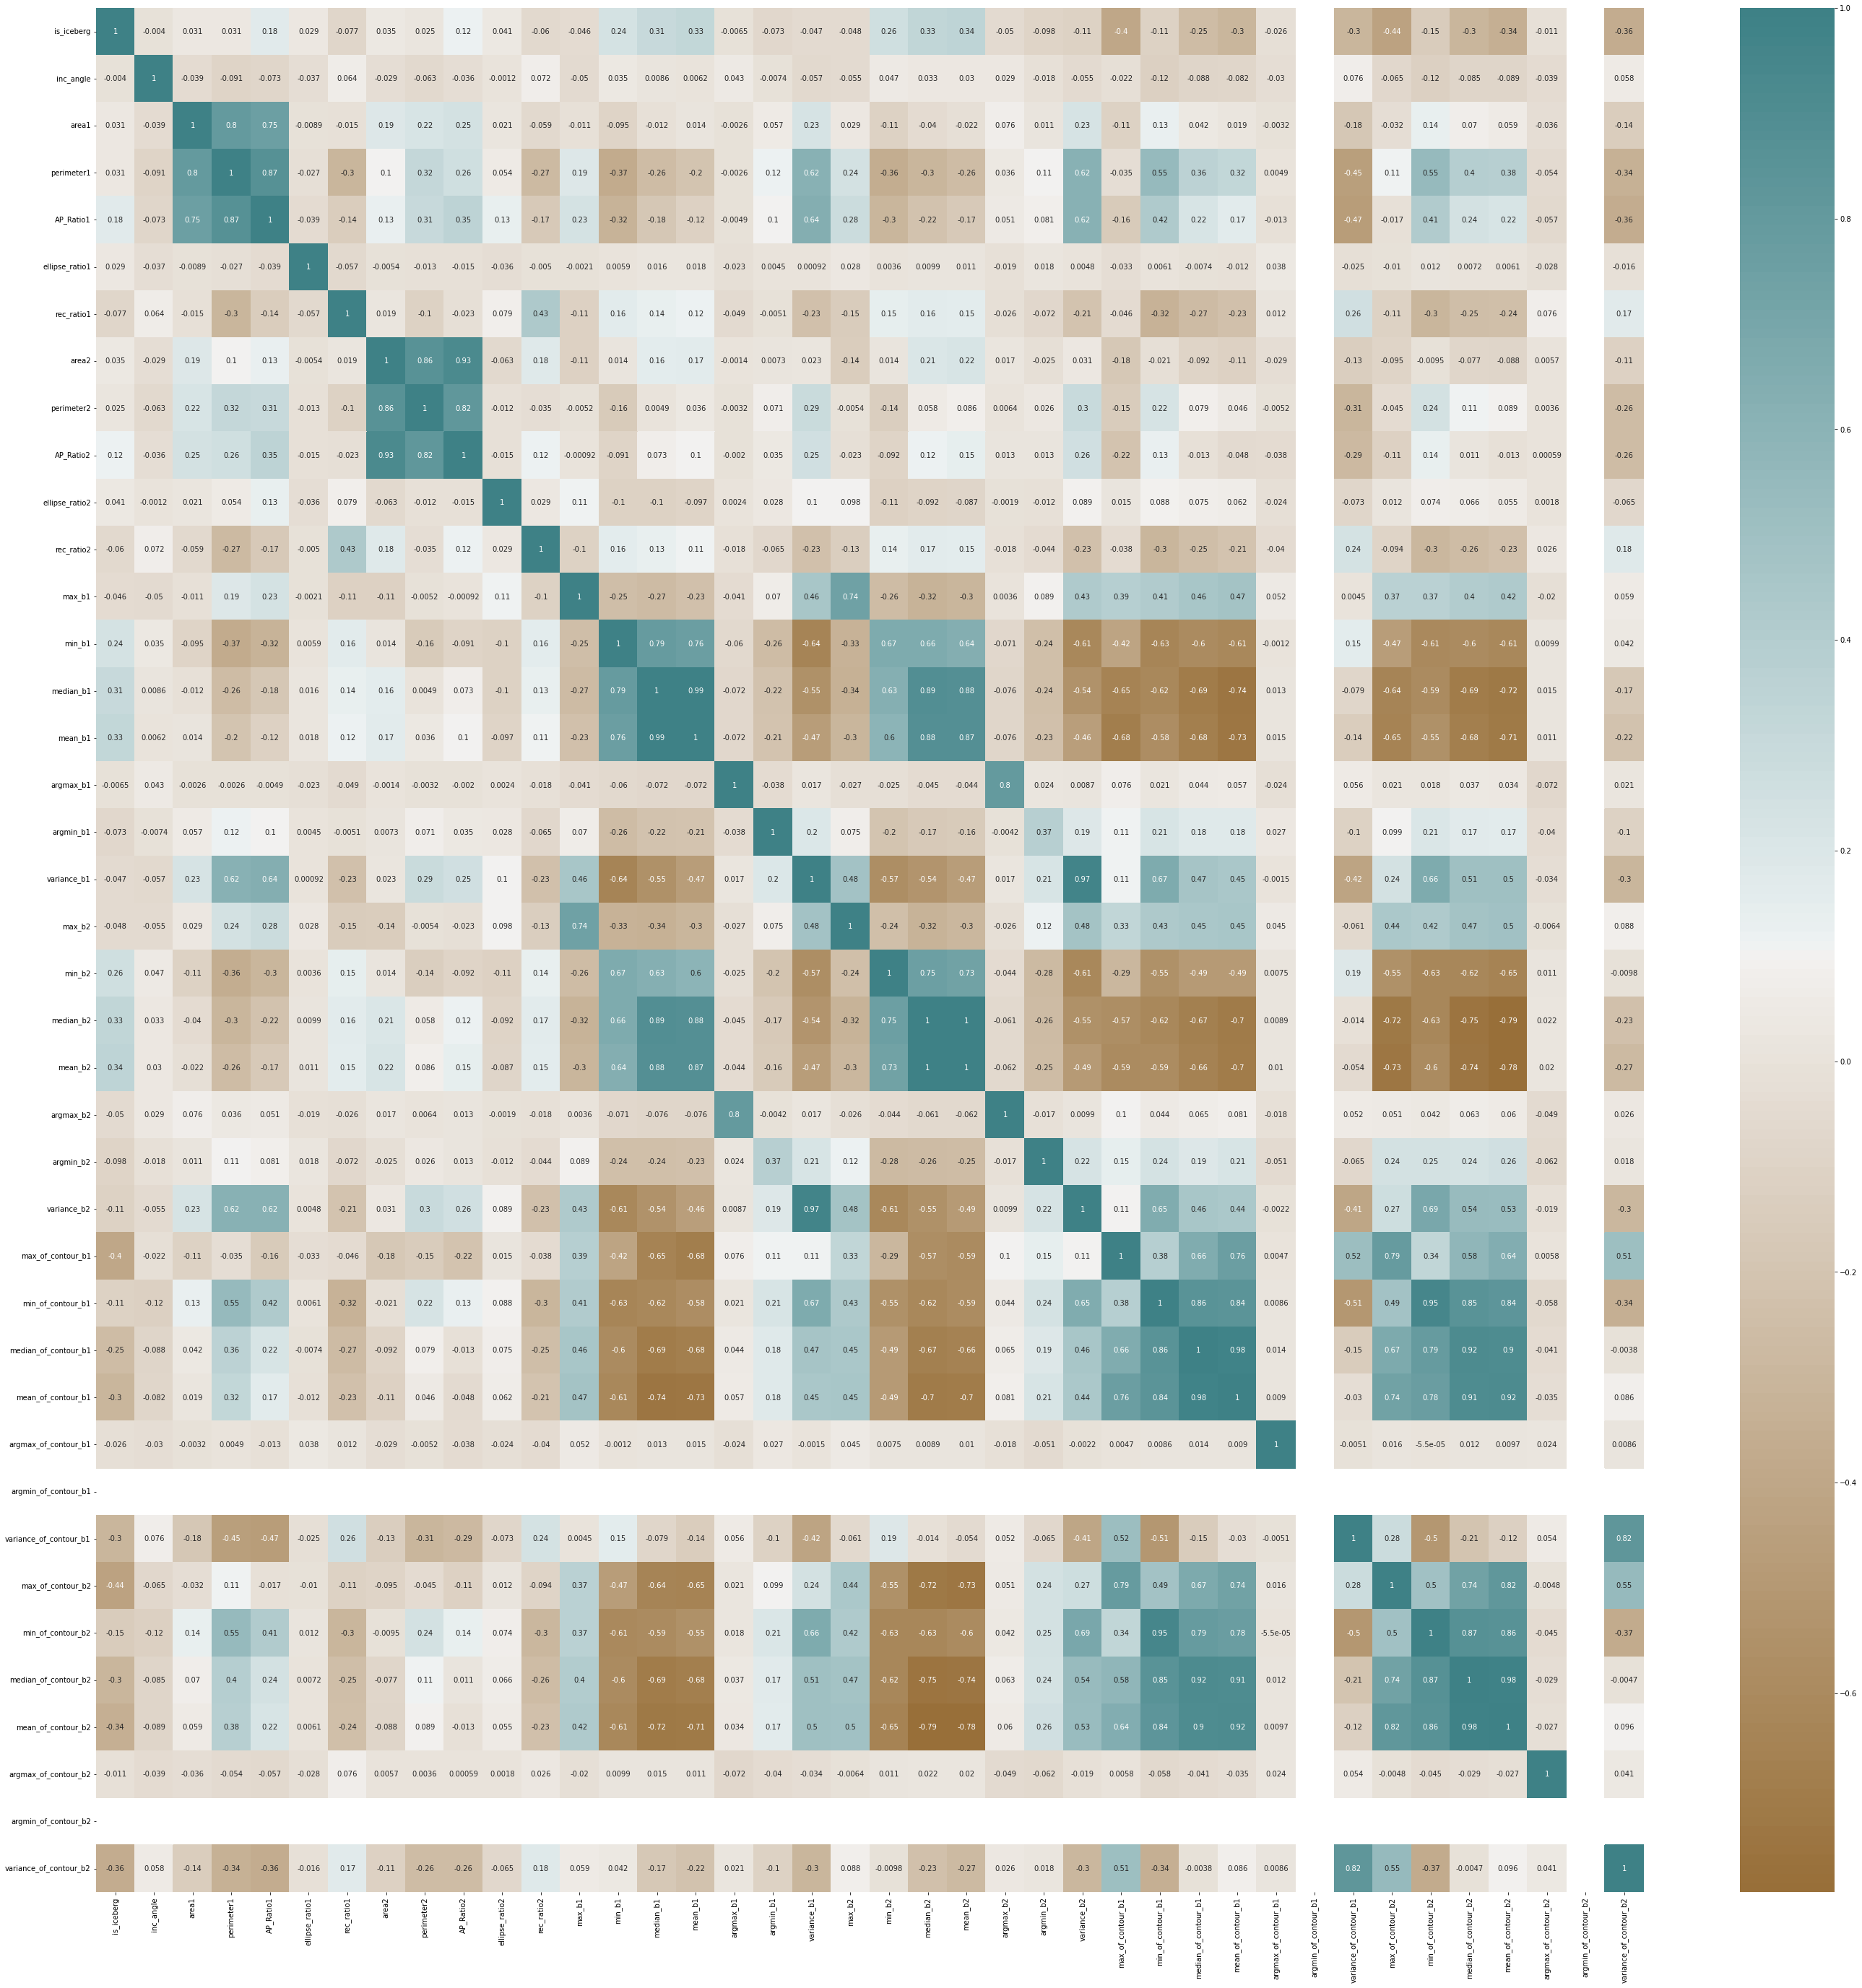

In [ ]:
stats_corr = df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).corr()
plt.figure(figsize = (48,48))
ax = sns.heatmap(stats_corr, annot = True, cmap = sns.diverging_palette(50, 200, n=200))

# Results

## On statistics only

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# selecting the prediction target and the model features
dfnew = df.dropna()
y = dfnew["is_iceberg"]
X_stats = dfnew.loc[:,['max_b1','median_b1','mean_b1','variance_b1','max_b2','median_b2','mean_b2','variance_b2',
           'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
           'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
           'area1','perimeter1','AP_Ratio1','ellipse_ratio1','rec_ratio1',
           'area2','perimeter2','AP_Ratio2','ellipse_ratio2','rec_ratio2']]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)

### DecisionTreeClassifier

In [ ]:
X_stats

,max_b1,median_b1,mean_b1,variance_b1,max_b2,median_b2,mean_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,variance_of_contour_b2,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2
486,0.763520,0.262176,0.272043,0.003019,0.738811,0.246106,0.254636,0.002476,0.273977,0.130744,0.180378,0.190231,0.001374,0.274700,0.119725,0.167851,0.177147,0.001737,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556
760,0.809186,0.249596,0.258900,0.003081,0.785444,0.231828,0.241830,0.002865,0.257232,0.097203,0.142007,0.149770,0.001690,0.286285,0.101574,0.137578,0.162455,0.002795,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622
1502,0.803208,0.366340,0.377665,0.003292,0.763137,0.462308,0.466680,0.002393,0.207015,0.066357,0.111964,0.113293,0.001388,0.116685,0.060460,0.074668,0.078985,0.000197,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500
682,0.738047,0.205832,0.211124,0.001810,0.717693,0.264332,0.269507,0.001368,0.282850,0.088742,0.134164,0.154729,0.003109,0.229686,0.067874,0.116616,0.124866,0.002120,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000
1324,0.780720,0.366813,0.370002,0.001265,0.766059,0.386247,0.388320,0.001178,0.254984,0.074531,0.110046,0.133584,0.003287,0.232614,0.074469,0.105407,0.122728,0.002296,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0.768739,0.298149,0.305605,0.002664,0.798853,0.341833,0.348840,0.002331,0.300178,0.102549,0.136940,0.152219,0.002297,0.281125,0.086463,0.114576,0.134172,0.002450,44.5,33.899495,1.312704,0.769865,0.794643,37.5,27.071068,1.385243,0.778593,0.852273
23,0.775070,0.358947,0.368040,0.003142,0.795647,0.400842,0.406780,0.003339,0.247930,0.102724,0.138786,0.146636,0.001372,0.226321,0.101342,0.119788,0.133248,0.000861,89.5,42.384776,2.111607,0.846210,0.662963,107.0,45.798990,2.336296,0.804830,0.664545
539,0.768208,0.191469,0.224903,0.012608,0.760559,0.205532,0.236949,0.010339,0.240036,0.139446,0.172646,0.177939,0.000745,0.217739,0.122613,0.152228,0.155972,0.000669,270.0,72.627417,3.717604,0.880999,0.784672,245.0,71.455844,3.428691,0.914600,0.774758
5,0.812462,0.227463,0.244949,0.006640,0.791498,0.269416,0.285761,0.004996,0.273760,0.108182,0.147770,0.164341,0.001969,0.282171,0.097918,0.136222,0.147597,0.002216,86.5,36.384776,2.377368,0.960494,0.757723,88.5,37.213203,2.378188,0.954217,0.775243


--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.794
--- Cross Validation Report ---
Mean accuracy score 0.798 with std 0.022
Mean f1 score 0.797 with std 0.034
Mean precision score 0.832 with std 0.016
Mean recall score 0.769 with std 0.075
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.82
 f1 : 0.822
 precision : 0.808
 recall : 0.836
Confusion matrix for the test sample :


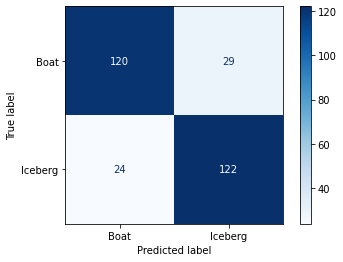

In [ ]:
df_stats = dfnew.loc[:,['is_iceberg',
            'max_b1','median_b1','mean_b1','variance_b1','max_b2','median_b2','mean_b2','variance_b2',
            'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
            'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
            'area1','perimeter1','AP_Ratio1','ellipse_ratio1','rec_ratio1',
            'area2','perimeter2','AP_Ratio2','ellipse_ratio2','rec_ratio2']]
er = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)

          
param_grid = [{
    'min_samples_leaf': [10],
    'max_features': [None]
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

In [ ]:
er.cross_proba_report()

--- Cross Validation with 0.5 Threshold Report ---
 accuracy : 0.795
 f1 : 0.802
 precision : 0.806
 recall : 0.797


--- Precision Recall Curves ---


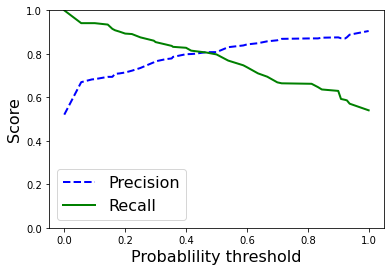

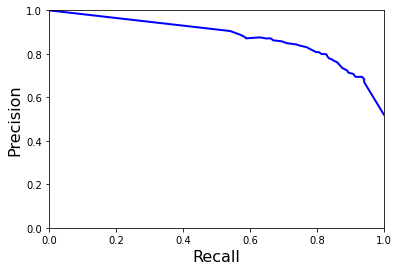

In [ ]:
er.plot_precision_recall()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.614
--- Cross Validation Report ---
Mean accuracy score 0.627 with std 0.037
Mean f1 score 0.63 with std 0.032
Mean precision score 0.653 with std 0.044
Mean recall score 0.61 with std 0.025
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.675
 f1 : 0.662
 precision : 0.681
 recall : 0.644
Confusion matrix for the test sample :


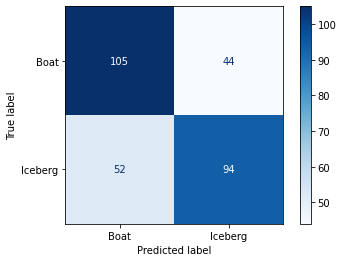

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)

###C-support Vector

--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 0.001} with f1 score 0.685
--- Cross Validation Report ---
Mean accuracy score 0.52 with std 0.0
Mean f1 score 0.685 with std 0.0
Mean precision score 0.52 with std 0.0
Mean recall score 1.0 with std 0.0
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :


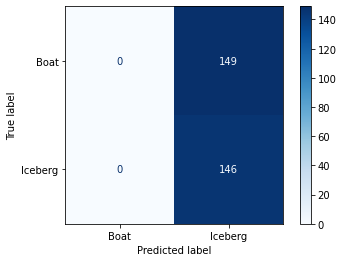

In [ ]:
from sklearn.svm import SVC


param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]


er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train

er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)



In [ ]:
#er.grid_cross_test_report(SVC(kernel='linear'), param_grid)

--- Grid Search Report ---
Best parameters for SVC(kernel='sigmoid') :
 {'C': 0.001} with f1 score 0.685
--- Cross Validation Report ---
Mean accuracy score 0.52 with std 0.0
Mean f1 score 0.685 with std 0.0
Mean precision score 0.52 with std 0.0
Mean recall score 1.0 with std 0.0
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :


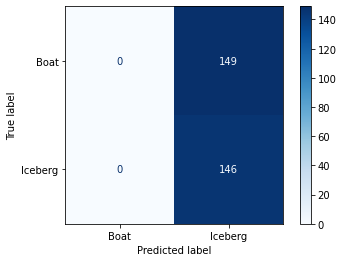

In [ ]:
er.grid_cross_test_report(SVC(kernel='sigmoid', gamma='scale'), param_grid)

###Gaussian Process

--- Cross Validation Report ---
Mean accuracy score 0.666 with std 0.023
Mean f1 score 0.667 with std 0.015
Mean precision score 0.694 with std 0.034
Mean recall score 0.643 with std 0.003
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.729
 f1 : 0.73
 precision : 0.72
 recall : 0.74
Confusion matrix for the test sample :


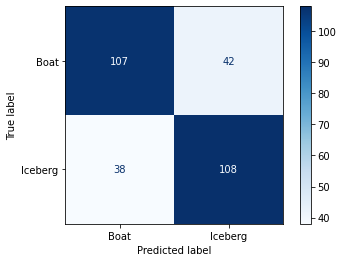

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))

### Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 6, 'n_estimators': 100} with f1 score 0.866
--- Cross Validation Report ---
Mean accuracy score 0.849 with std 0.008
Mean f1 score 0.858 with std 0.011
Mean precision score 0.842 with std 0.014
Mean recall score 0.876 with std 0.037
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.854
 f1 : 0.859
 precision : 0.824
 recall : 0.897
Confusion matrix for the test sample :


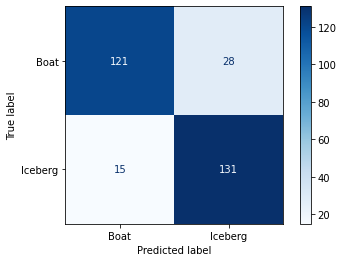

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{
    'min_samples_leaf': range(2,15,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]
er.grid_cross_test_report(RandomForestClassifier(), param_grid)

###Neural net

--- Grid Search Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overflow encountered in matmul



Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 700, 'solver': 'adam'} with f1 score 0.786
--- Cross Validation Report ---
Mean accuracy score 0.768 with std 0.024
Mean f1 score 0.777 with std 0.026
Mean precision score 0.777 with std 0.025
Mean recall score 0.778 with std 0.044
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.814
 f1 : 0.811
 precision : 0.814
 recall : 0.808
Confusion matrix for the test sample :


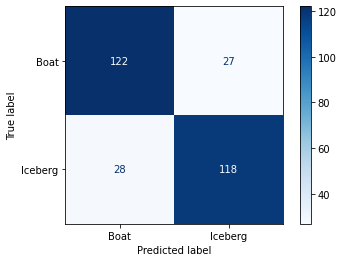

In [ ]:
from sklearn.neural_network import MLPClassifier

param_grid = [{'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [700],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}]
er.grid_cross_test_report(MLPClassifier(), param_grid)

### Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.833 with std 0.01
Mean f1 score 0.84 with std 0.01
Mean precision score 0.839 with std 0.008
Mean recall score 0.841 with std 0.013
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.827
 f1 : 0.833
 precision : 0.799
 recall : 0.87
Confusion matrix for the test sample :


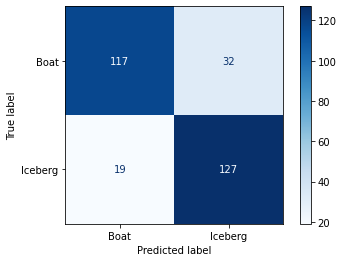

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

er.cross_test_report(AdaBoostClassifier())

## On PCA data only

In [ ]:
# Applying a PCA and saving for differents PCs

# I could have used a pipeline...
def get_pca_df(df, X, pcs):
  X_std = StandardScaler().fit_transform(X)
  pca = PCA(pcs).fit(X_std)
  res = pd.DataFrame(pca.transform(X_std),columns=['PC%s' % _ for _ in range(pcs)], index=df.index)
  res = res.join(df['is_iceberg'])
  res = res.dropna()
  return res

In [ ]:
pca_5 = get_pca_df(df, naive_base_pretreated, 5)
pca_10 = get_pca_df(df, naive_base_pretreated, 10)
pca_20 = get_pca_df(df, naive_base_pretreated, 20)
pca_50 = get_pca_df(df, naive_base_pretreated, 50)
pca_100 = get_pca_df(df, naive_base_pretreated, 100)
pca_200 = get_pca_df(df, naive_base_pretreated, 200)
pca_500 = get_pca_df(df, naive_base_pretreated, 500)

In [ ]:
pca_5

,PC0,PC1,PC2,PC3,PC4,is_iceberg
486,-58.560469,-18.687751,-4.375629,-18.261208,-7.505930,0
760,-75.509121,-15.812607,-4.872814,-5.673984,-2.222567,1
1502,114.173050,19.607882,28.220128,-0.327816,-1.112581,1
682,-85.967157,28.026436,-12.495365,-14.401733,2.698459,1
1324,74.345651,-13.916493,-8.358526,-8.646225,4.090177,1
...,...,...,...,...,...,...
23,76.974630,-2.173236,1.965174,18.696266,-4.272724,1
539,-105.755674,2.609222,48.636862,6.221364,-29.189129,0
142,149.820572,-34.906577,2.240313,-8.553021,0.633760,0
5,-64.921276,13.788227,24.818318,-9.945643,-5.236132,1


### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.711
--- Cross Validation Report ---
Mean accuracy score 0.713 with std 0.065
Mean f1 score 0.688 with std 0.071
Mean precision score 0.71 with std 0.083
Mean recall score 0.671 with std 0.086
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.745
 f1 : 0.713
 precision : 0.797
 recall : 0.646
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.701
--- Cross Validation Report ---
Mean accuracy score 0.747 with std 0.053
Mean f1 score 0.725 with std 0.064
Mean precision score 0.741 with std 0.052
Mean recall score 0.711 with std 0.082
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.754
 f1 : 0.73
 precision : 0.793
 recall : 0.677
Confusion matrix for the test sample :
--- Grid Search Report

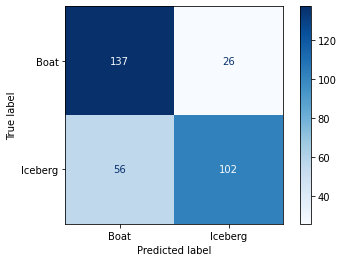

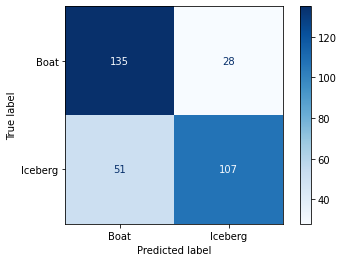

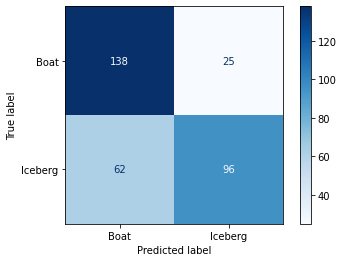

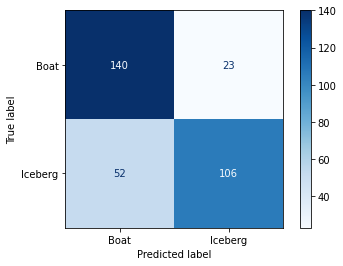

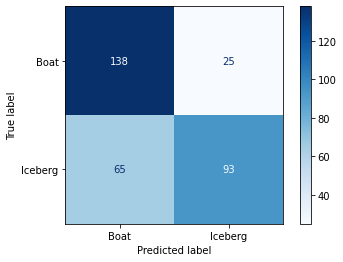

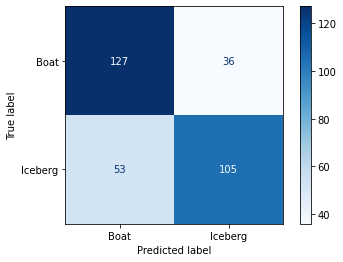

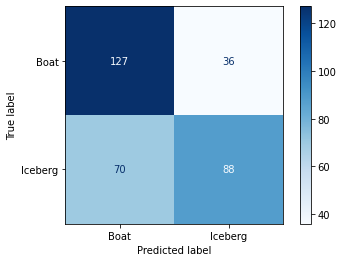

In [ ]:
param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 3

train_scores = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores.append(er.best_scores_t)

In [ ]:
train_scores

[{'accuracy': 0.713, 'f1': 0.688, 'precision': 0.71, 'recall': 0.671},
 {'accuracy': 0.747, 'f1': 0.725, 'precision': 0.741, 'recall': 0.711},
 {'accuracy': 0.75, 'f1': 0.735, 'precision': 0.731, 'recall': 0.742},
 {'accuracy': 0.742, 'f1': 0.727, 'precision': 0.728, 'recall': 0.731},
 {'accuracy': 0.724, 'f1': 0.705, 'precision': 0.712, 'recall': 0.702},
 {'accuracy': 0.725, 'f1': 0.7, 'precision': 0.719, 'recall': 0.682},
 {'accuracy': 0.7, 'f1': 0.672, 'precision': 0.694, 'recall': 0.658}]

In [ ]:
x_plot = [5, 10, 20, 50, 100, 200, 500]
y_plot1 = [a.get('accuracy') for a in train_scores]
y_plot2 = [a.get('f1') for a in train_scores]
y_plot3 = [a.get('precision') for a in train_scores]
y_plot4 = [a.get('recall') for a in train_scores]

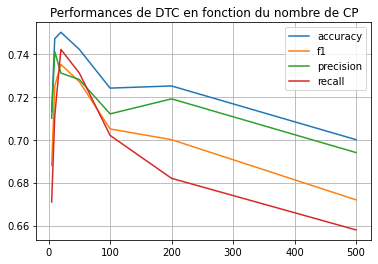

In [ ]:
plt.plot(x_plot, y_plot1, label='accuracy')
plt.plot(x_plot, y_plot2, label='f1')
plt.plot(x_plot, y_plot3, label='precision')
plt.plot(x_plot, y_plot4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.745
--- Cross Validation Report ---
Mean accuracy score 0.773 with std 0.046
Mean f1 score 0.748 with std 0.058
Mean precision score 0.782 with std 0.052
Mean recall score 0.721 with std 0.085
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.773
 precision : 0.817
 recall : 0.734
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.752
--- Cross Validation Report ---
Mean accuracy score 0.784 with std 0.049
Mean f1 score 0.753 with std 0.062
Mean precision score 0.809 with std 0.049
Mean recall score 0.706 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.791
 f1 : 0.767
 precision : 0.853
 recall : 0.696
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n

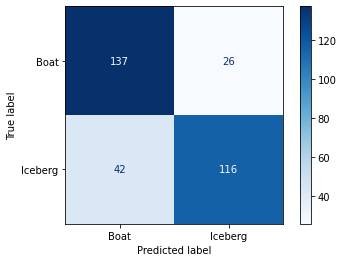

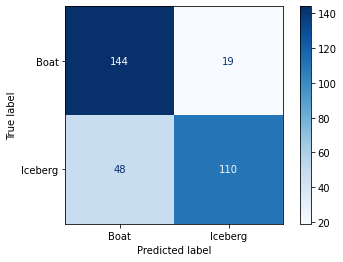

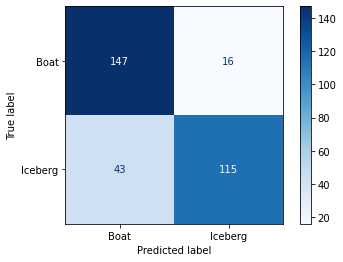

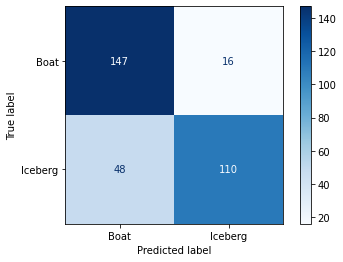

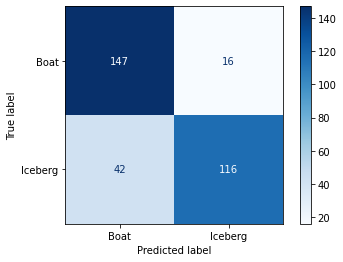

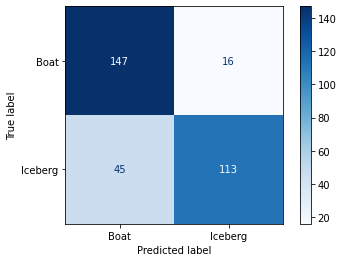

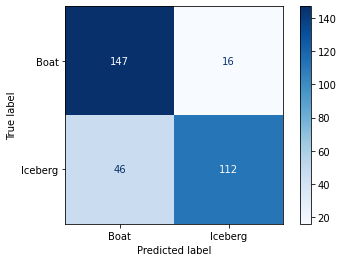

In [ ]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

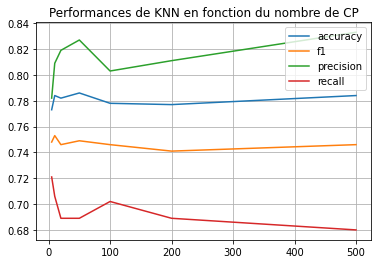

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

###C-support Vector


--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.786
--- Cross Validation Report ---
Mean accuracy score 0.79 with std 0.031
Mean f1 score 0.787 with std 0.034
Mean precision score 0.754 with std 0.035
Mean recall score 0.825 with std 0.063
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.81
 f1 : 0.805
 precision : 0.813
 recall : 0.797
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.804
--- Cross Validation Report ---
Mean accuracy score 0.803 with std 0.049
Mean f1 score 0.795 with std 0.054
Mean precision score 0.779 with std 0.055
Mean recall score 0.815 with std 0.076
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.816
 f1 : 0.807
 precision : 0.837
 recall : 0.778
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 1.0} with f1 score 0.809
--- Cross Validation Report ---
Mean accu

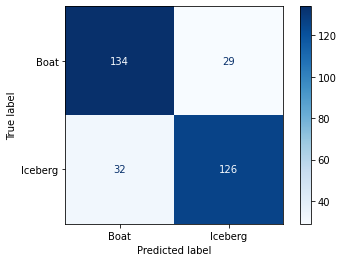

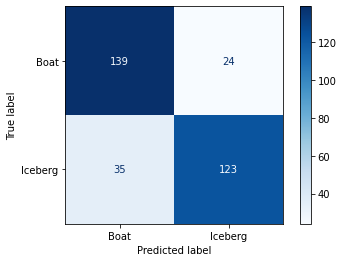

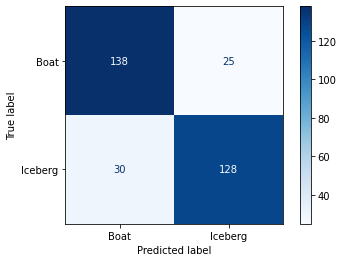

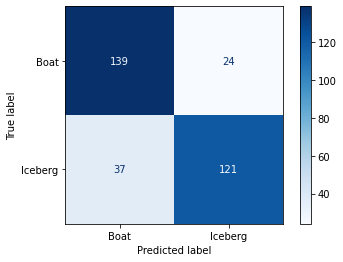

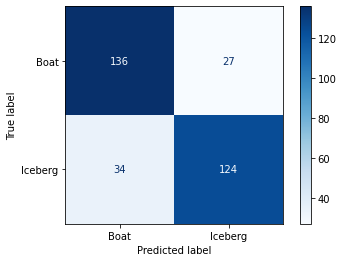

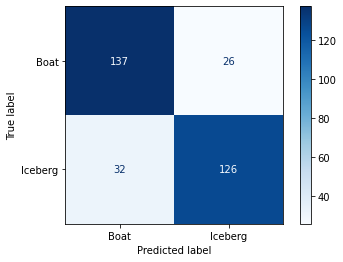

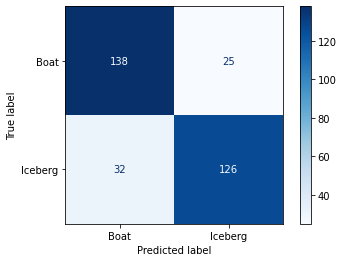

In [ ]:
param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]


er.cv_cv = 3
train_scores_svc= []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)
  train_scores_svc.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_svc]
y_p2 = [a.get('f1') for a in train_scores_svc]
y_p3 = [a.get('precision') for a in train_scores_svc]
y_p4 = [a.get('recall') for a in train_scores_svc]

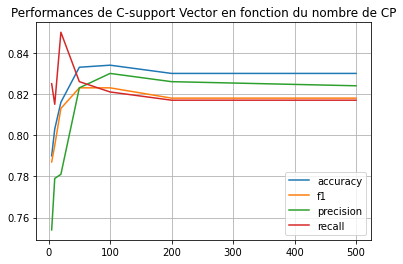

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de C-support Vector en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Gaussian Process

--- Cross Validation Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Mean accuracy score 0.736 with std 0.11
Mean f1 score 0.624 with std 0.314
Mean precision score 0.612 with std 0.309
Mean recall score 0.639 with std 0.321
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.807
 f1 : 0.797
 precision : 0.824
 recall : 0.772
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.797 with std 0.048
Mean f1 score 0.786 with std 0.056
Mean precision score 0.781 with std 0.056
Mean recall score 0.797 with std 0.089
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.813
 f1 : 0.803
 precision : 0.836
 recall : 0.772
Confusion matrix for the test sample :
--- Cross Validation Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

Mean accuracy score 0.582 with std 0.108
Mean f1 score 0.154 with std 0.309
Mean precision score 0.165 with std 0.33
Mean recall score 0.147 with std 0.294
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.798
 f1 : 0.784
 precision : 0.825
 recall : 0.747
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.752 with std 0.041
Mean f1 score 0.729 with std 0.051
Mean precision score 0.748 with std 0.05
Mean recall score 0.717 with std 0.084
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.775
 precision : 0.812
 recall : 0.741
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.739 with std 0.048
Mean f1 score 0.714 with std 0.055
Mean precision score 0.741 with std 0.066
Mean recall score 0.695 with std 0.084
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.782
 f1 : 0.77
 precision : 0.801
 recall : 0.741
Confusion matrix for the te

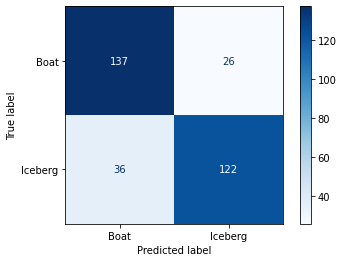

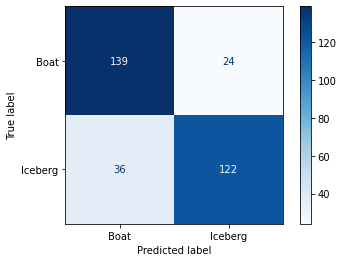

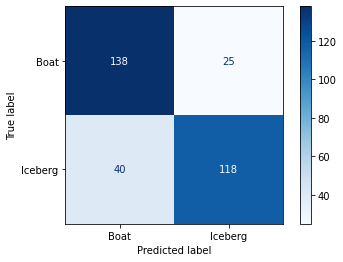

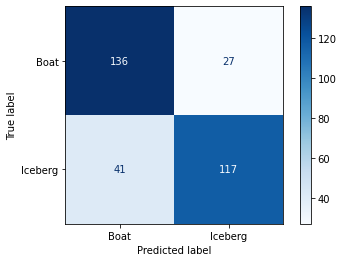

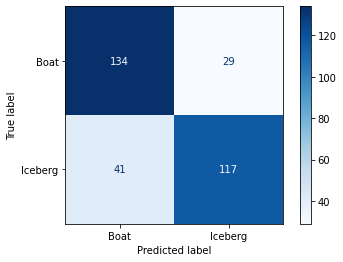

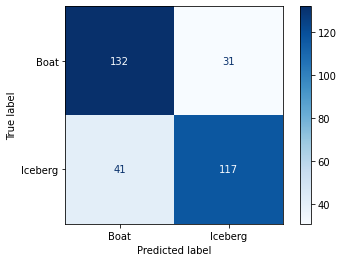

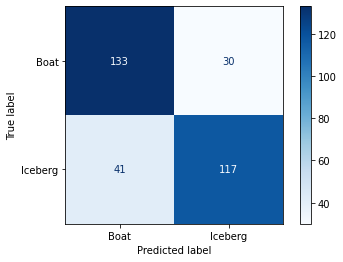

In [ ]:
train_scores_GP = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))
  train_scores_GP.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_GP]
y_p2 = [a.get('f1') for a in train_scores_GP]
y_p3 = [a.get('precision') for a in train_scores_GP]
y_p4 = [a.get('recall') for a in train_scores_GP]

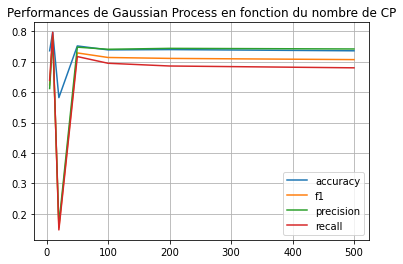

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Gaussian Process en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 6, 'n_estimators': 100} with f1 score 0.784
--- Cross Validation Report ---
Mean accuracy score 0.793 with std 0.038
Mean f1 score 0.785 with std 0.038
Mean precision score 0.775 with std 0.056
Mean recall score 0.799 with std 0.057
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.794
 f1 : 0.783
 precision : 0.815
 recall : 0.753
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 100} with f1 score 0.801
--- Cross Validation Report ---
Mean accuracy score 0.793 with std 0.041
Mean f1 score 0.78 with std 0.048
Mean precision score 0.779 with std 0.044
Mean recall score 0.786 with std 0.079
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.81
 f1 : 0.8
 precision : 0.83
 recall : 0.772
Confusion matrix f

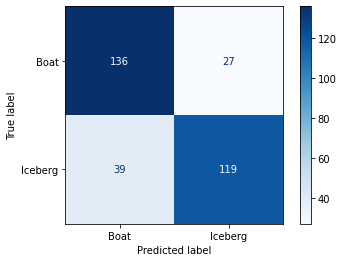

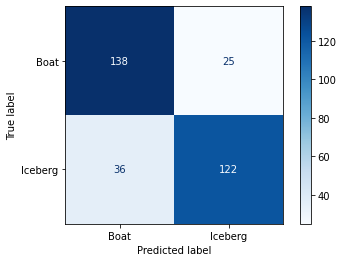

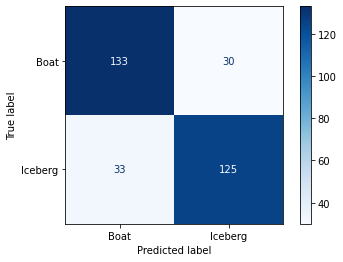

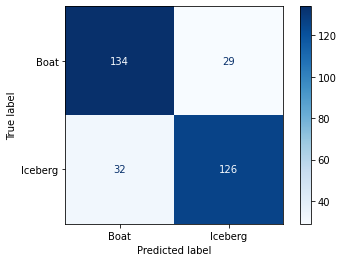

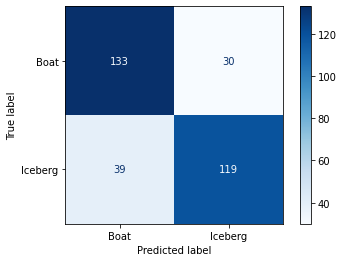

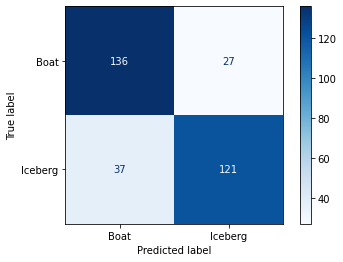

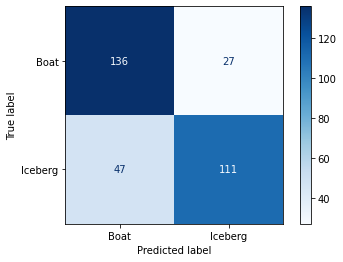

In [ ]:
param_grid = [{
    'min_samples_leaf': range(2,12,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]

er.cv_cv = 3
train_scores_RF= []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(RandomForestClassifier(), param_grid)
  train_scores_RF.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_RF]
y_p2 = [a.get('f1') for a in train_scores_RF]
y_p3 = [a.get('precision') for a in train_scores_RF]
y_p4 = [a.get('recall') for a in train_scores_RF]

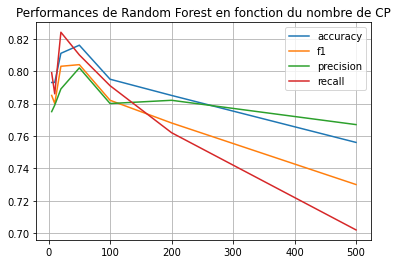

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Random Forest en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Neural Test

--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.693
--- Cross Validation Report ---
Mean accuracy score 0.71 with std 0.051
Mean f1 score 0.694 with std 0.056
Mean precision score 0.691 with std 0.058
Mean recall score 0.702 with std 0.079
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.741
 f1 : 0.743
 precision : 0.727
 recall : 0.759
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.725
--- Cross Validation Report ---
Mean accuracy score 0.736 with std 0.035
Mean f1 score 0.718 with std 0.037
Mean precision score 0.725 with std 0.048
Mean recall score 0.715 with std 0.058
--- Test

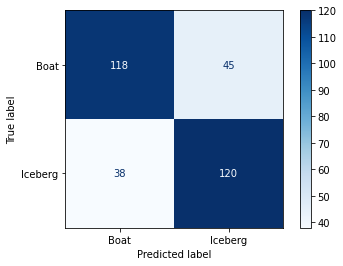

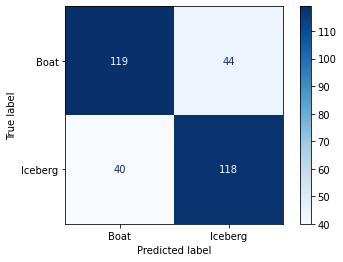

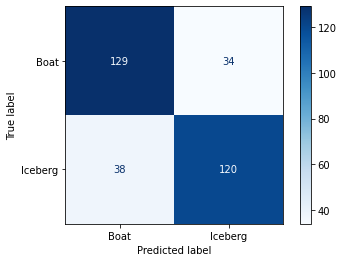

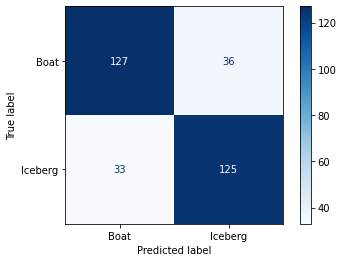

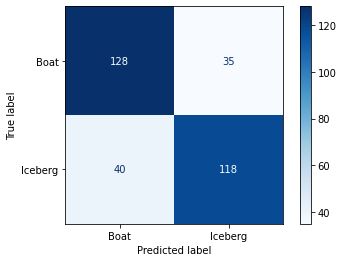

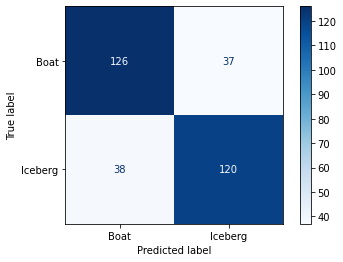

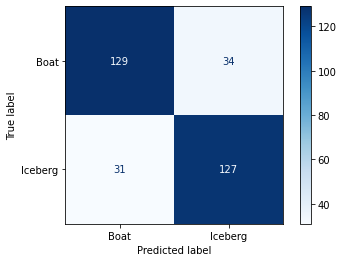

In [ ]:
param_grid = [{'activation': ['tanh'],
               'alpha': [0.0001,0.005],
               'hidden_layer_sizes': [(150, 100, 50)],
               'learning_rate': ['adaptive'],
               'max_iter': [400],
               'solver': ['adam']}]

er.cv_cv = 3
train_scores_NeuralTest= []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(MLPClassifier(), param_grid)
  train_scores_NeuralTest.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_NeuralTest]
y_p2 = [a.get('f1') for a in train_scores_NeuralTest]
y_p3 = [a.get('precision') for a in train_scores_NeuralTest]
y_p4 = [a.get('recall') for a in train_scores_NeuralTest]

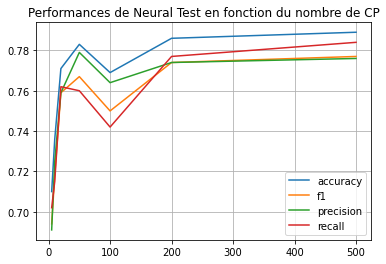

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Neural Test en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.755 with std 0.051
Mean f1 score 0.747 with std 0.051
Mean precision score 0.73 with std 0.064
Mean recall score 0.768 with std 0.057
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.766
 f1 : 0.751
 precision : 0.79
 recall : 0.715
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.768 with std 0.046
Mean f1 score 0.752 with std 0.054
Mean precision score 0.756 with std 0.049
Mean recall score 0.75 with std 0.075
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.785
 f1 : 0.768
 precision : 0.82
 recall : 0.722
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.786 with std 0.034
Mean f1 score 0.771 with std 0.037
Mean precision score 0.782 with std 0.056
Mean recall score 0.766 with std 0.067
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.819
 f1 : 0.81
 precision : 0.838
 recall : 0.7

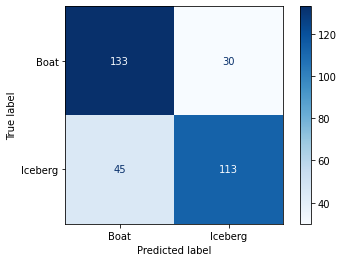

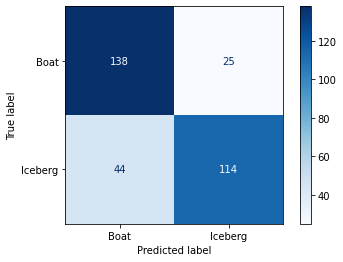

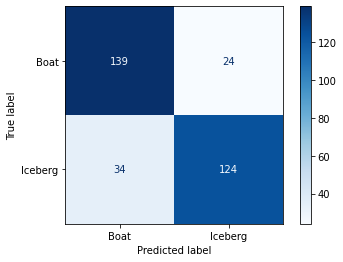

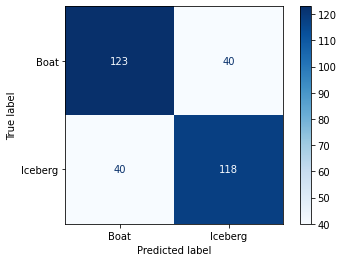

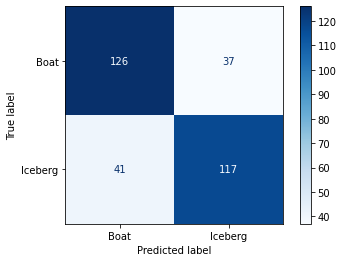

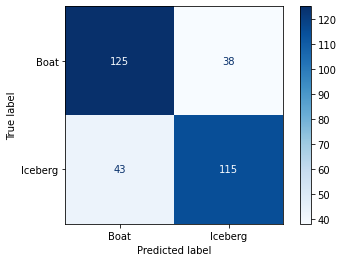

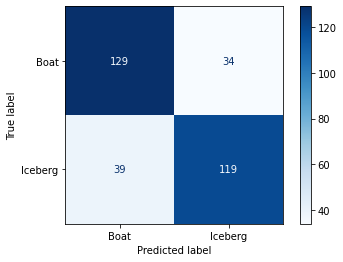

In [ ]:
er.cv_cv = 3

train_scores_Adaboost = []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(AdaBoostClassifier())
  train_scores_Adaboost.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_Adaboost]
y_p2 = [a.get('f1') for a in train_scores_Adaboost]
y_p3 = [a.get('precision') for a in train_scores_Adaboost]
y_p4 = [a.get('recall') for a in train_scores_Adaboost]

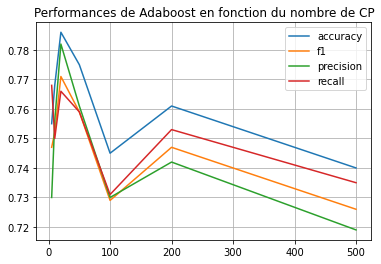

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Adaboost en fonction du nombre de CP')
plt.grid(True)
plt.show()

## On PCA and statistics

In [ ]:
df_stats = df_stats.loc[:,~df_stats.columns.duplicated()]
df_5 = df_stats.join(pca_5.drop('is_iceberg',axis=1)).dropna()
df_20 = df_stats.join(pca_20.drop('is_iceberg',axis=1)).dropna()
df_50 = df_stats.join(pca_50.drop('is_iceberg',axis=1)).dropna()
df_100 = df_stats.join(pca_100.drop('is_iceberg',axis=1)).dropna()

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.806
--- Cross Validation Report ---
Mean accuracy score 0.807 with std 0.055
Mean f1 score 0.809 with std 0.059
Mean precision score 0.83 with std 0.047
Mean recall score 0.791 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.814
 f1 : 0.808
 precision : 0.823
 recall : 0.795
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.786
--- Cross Validation Report ---
Mean accuracy score 0.798 with std 0.044
Mean f1 score 0.804 with std 0.049
Mean precision score 0.808 with std 0.037
Mean recall score 0.804 with std 0.077
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.79
 f1 : 0.792
 precision : 0.776
 recall : 0.808
Confusion matrix for the test sample :
--- Grid Search Repo

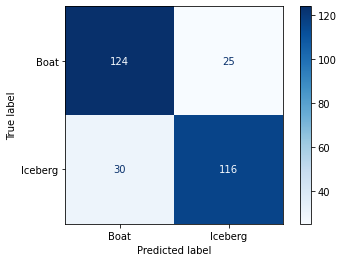

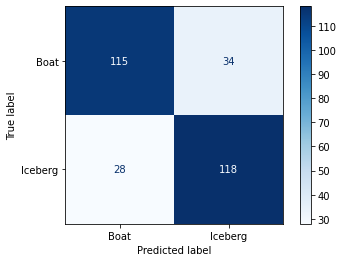

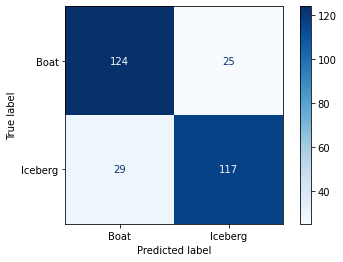

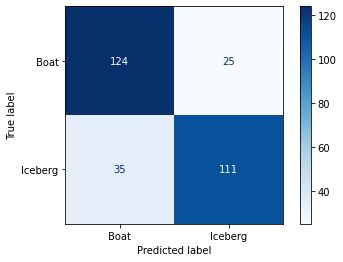

In [ ]:
train_scores_mix = []

param_grid = [{
    'min_samples_leaf': [10],
    'max_features': [None]
}]

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores_mix.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100]
y1 = [a.get('accuracy') for a in train_scores_mix]
y2 = [a.get('f1') for a in train_scores_mix]
y3 = [a.get('precision') for a in train_scores_mix]
y4 = [a.get('recall') for a in train_scores_mix]

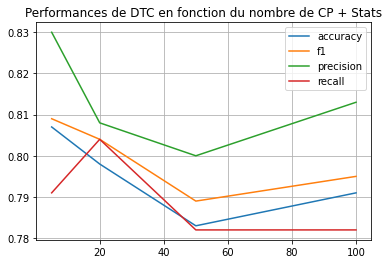

In [ ]:
plt.plot(x_p, y1, label='accuracy')
plt.plot(x_p, y2, label='f1')
plt.plot(x_p, y3, label='precision')
plt.plot(x_p, y4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP + Stats')
plt.grid(True)
plt.show()

###KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.811
--- Cross Validation Report ---
Mean accuracy score 0.803 with std 0.028
Mean f1 score 0.809 with std 0.031
Mean precision score 0.812 with std 0.023
Mean recall score 0.808 with std 0.049
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.797
 f1 : 0.801
 precision : 0.776
 recall : 0.829
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 12} with f1 score 0.82
--- Cross Validation Report ---
Mean accuracy score 0.813 with std 0.018
Mean f1 score 0.819 with std 0.019
Mean precision score 0.824 with std 0.02
Mean recall score 0.815 with std 0.034
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.783
 f1 : 0.785
 precision : 0.77
 recall : 0.801
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_ne

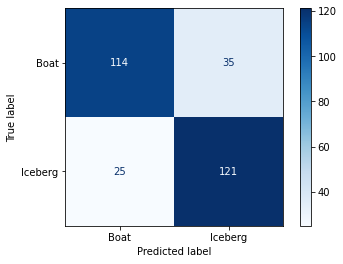

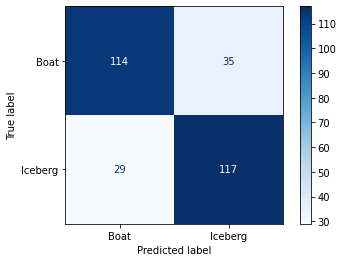

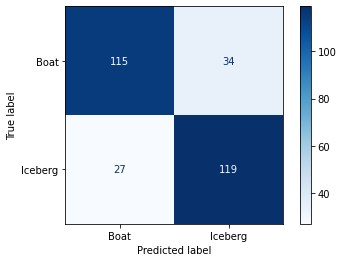

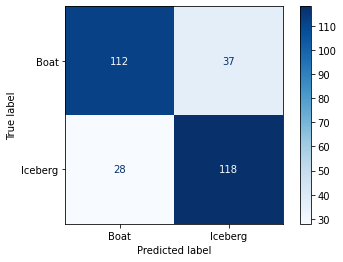

In [ ]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

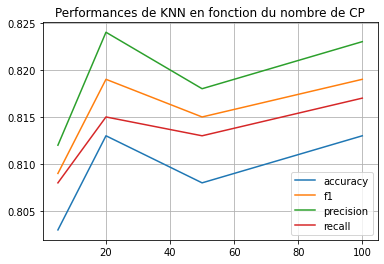

In [ ]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

###C-support Vector


--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.707
--- Cross Validation Report ---
Mean accuracy score 0.547 with std 0.075
Mean f1 score 0.695 with std 0.029
Mean precision score 0.546 with std 0.073
Mean recall score 0.98 with std 0.06
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.715
--- Cross Validation Report ---
Mean accuracy score 0.551 with std 0.089
Mean f1 score 0.7 with std 0.042
Mean precision score 0.55 with std 0.086
Mean recall score 0.984 with std 0.047
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.715
--- Cross Validation Report ---
Mean accuracy s

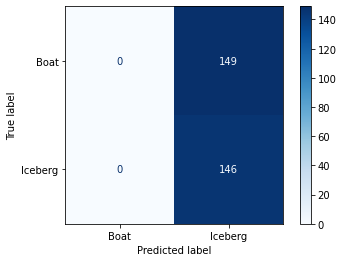

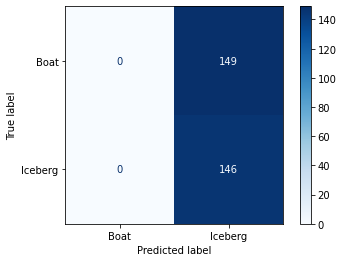

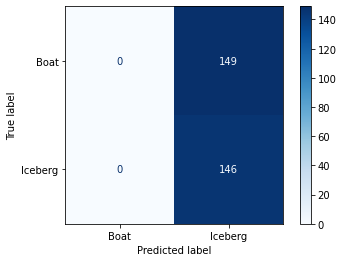

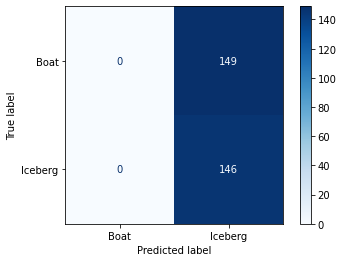

In [ ]:
from sklearn.svm import SVC


param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]

er.cv_cv = 3

train_scores_SVC = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)
  train_scores_SVC.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_SVC]
y_p2 = [a.get('f1') for a in train_scores_SVC]
y_p3 = [a.get('precision') for a in train_scores_SVC]
y_p4 = [a.get('recall') for a in train_scores_SVC]

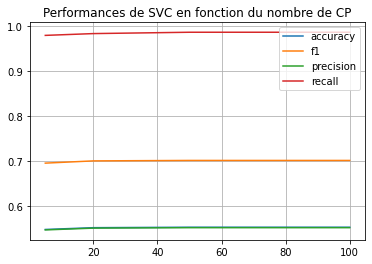

In [ ]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de SVC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### Gaussian Process

--- Cross Validation Report ---
Mean accuracy score 0.774 with std 0.029
Mean f1 score 0.793 with std 0.032
Mean precision score 0.758 with std 0.027
Mean recall score 0.834 with std 0.069
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.739
 f1 : 0.746
 precision : 0.72
 recall : 0.774
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.779 with std 0.039
Mean f1 score 0.787 with std 0.038
Mean precision score 0.789 with std 0.039
Mean recall score 0.787 with std 0.057
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.773
 f1 : 0.768
 precision : 0.776
 recall : 0.76
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.772 with std 0.036
Mean f1 score 0.776 with std 0.039
Mean precision score 0.792 with std 0.038
Mean recall score 0.765 with std 0.064
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.766
 f1 : 0.76
 precision : 0.773
 recall : 0

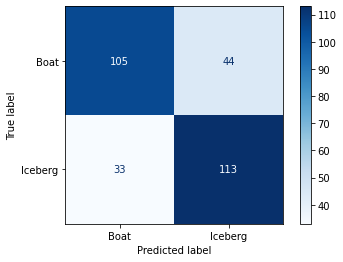

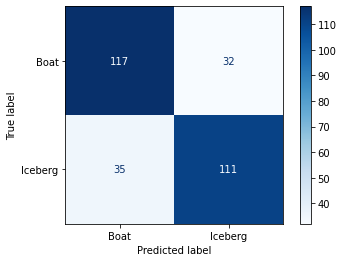

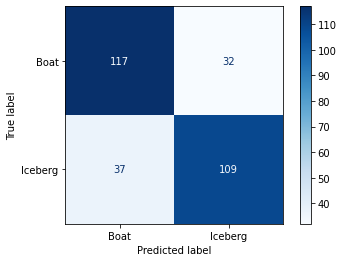

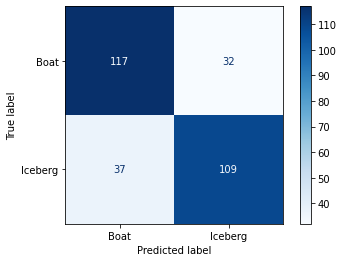

In [ ]:
er.cv_cv = 3

train_scores_GP = []

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))
  train_scores_GP.append(er.best_scores_t)


In [ ]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_GP]
y_p2 = [a.get('f1') for a in train_scores_GP]
y_p3 = [a.get('precision') for a in train_scores_GP]
y_p4 = [a.get('recall') for a in train_scores_GP]

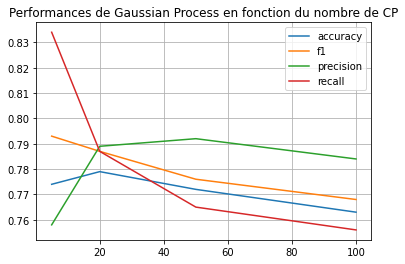

In [ ]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Gaussian Process en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100} with f1 score 0.86
--- Cross Validation Report ---
Mean accuracy score 0.858 with std 0.026
Mean f1 score 0.867 with std 0.027
Mean precision score 0.848 with std 0.027
Mean recall score 0.889 with std 0.053
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.868
 f1 : 0.87
 precision : 0.845
 recall : 0.897
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 100} with f1 score 0.865
--- Cross Validation Report ---
Mean accuracy score 0.854 with std 0.02
Mean f1 score 0.863 with std 0.021
Mean precision score 0.84 with std 0.03
Mean recall score 0.891 with std 0.046
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.847
 f1 : 0.853
 precision : 0.814
 recall : 0.897
Confusion matrix f

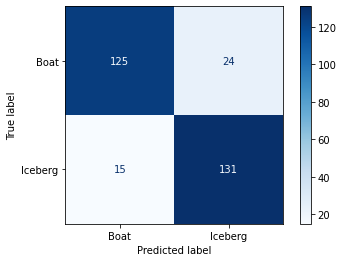

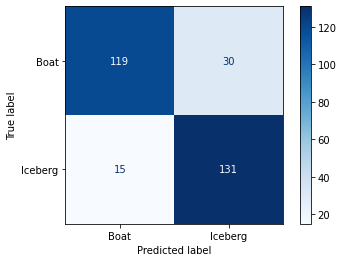

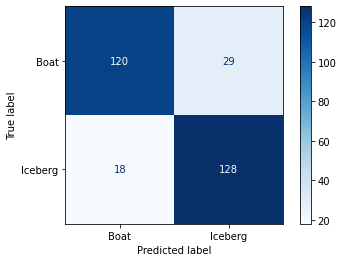

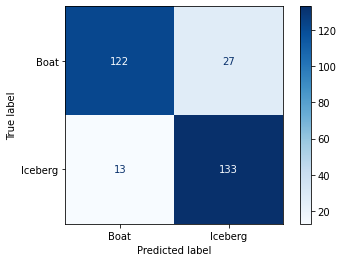

In [ ]:
param_grid = [{
    'min_samples_leaf': range(2,4,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]


er.cv_cv = 3

train_scores_RF = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(RandomForestClassifier(), param_grid)
  train_scores_RF.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_RF]
y_p2 = [a.get('f1') for a in train_scores_RF]
y_p3 = [a.get('precision') for a in train_scores_RF]
y_p4 = [a.get('recall') for a in train_scores_RF]

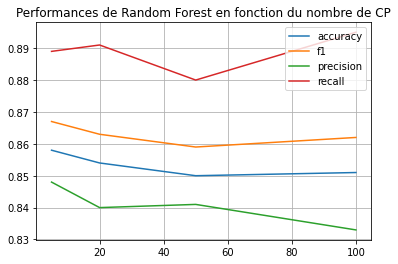

In [ ]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Random Forest en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier

--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.792
--- Cross Validation Report ---
Mean accuracy score 0.785 with std 0.058
Mean f1 score 0.796 with std 0.06
Mean precision score 0.782 with std 0.05
Mean recall score 0.813 with std 0.084
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.766
 f1 : 0.772
 precision : 0.745
 recall : 0.801
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.837
--- Cross Validation Report ---
Mean accuracy score 0.822 with std 0.037
Mean f1 score 0.832 with std 0.035
Mean precision score 0.818 with std 0.038
Mean recall score 0.848 with std 0.045
--- Test 

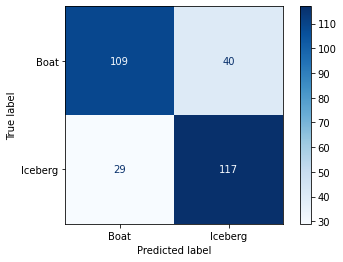

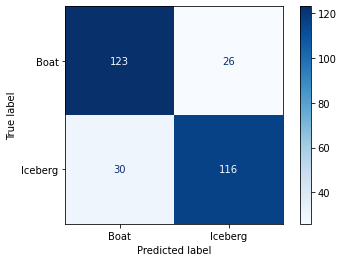

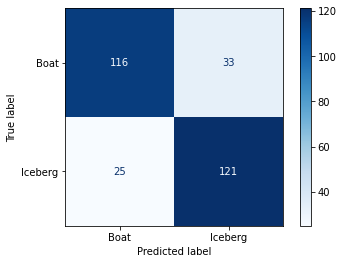

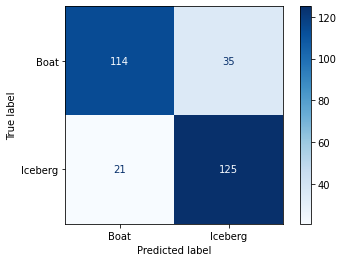

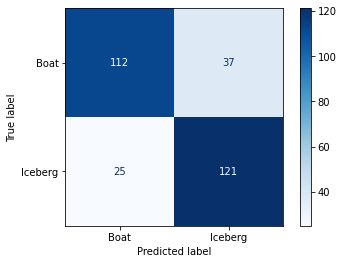

In [ ]:
param_grid = [{'activation': ['tanh'],
               'alpha': [0.0001,0.005],
               'hidden_layer_sizes': [(150, 100, 50)],
               'learning_rate': ['adaptive'],
               'max_iter': [400],
               'solver': ['adam']}]



er.cv_cv = 3

train_scores_MLPC = []

er.grid_cross_test_report

df_500=df_stats.join(pca_100.drop('is_iceberg',axis=1)).dropna()

for dtset in [df_5, df_20, df_50, df_100, df_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(MLPClassifier(), param_grid)
  train_scores_MLPC.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100, 500]
y_p1 = [a.get('accuracy') for a in train_scores_MLPC]
y_p2 = [a.get('f1') for a in train_scores_MLPC]
y_p3 = [a.get('precision') for a in train_scores_MLPC]
y_p4 = [a.get('recall') for a in train_scores_MLPC]

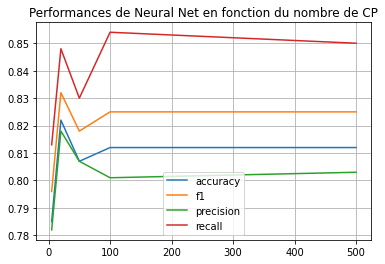

In [ ]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Neural Net en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.838 with std 0.018
Mean f1 score 0.845 with std 0.017
Mean precision score 0.844 with std 0.041
Mean recall score 0.85 with std 0.05
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.803
 f1 : 0.809
 precision : 0.778
 recall : 0.842
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.852 with std 0.03
Mean f1 score 0.858 with std 0.028
Mean precision score 0.856 with std 0.046
Mean recall score 0.863 with std 0.039
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.81
 f1 : 0.813
 precision : 0.792
 recall : 0.836
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.822 with std 0.028
Mean f1 score 0.831 with std 0.026
Mean precision score 0.821 with std 0.035
Mean recall score 0.843 with std 0.036
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.793
 f1 : 0.797
 precision : 0.774
 recall : 0.

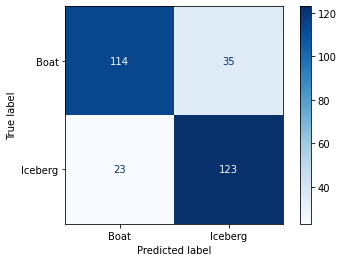

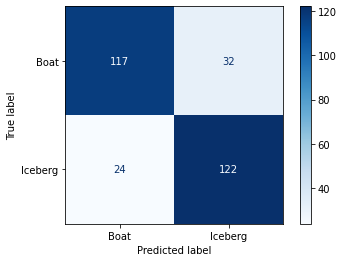

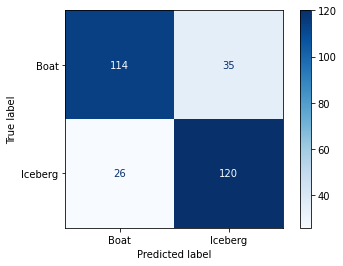

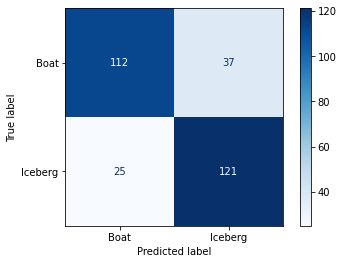

In [ ]:


er.cv_cv = 3

train_scores_Adaboost = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(AdaBoostClassifier())
  train_scores_Adaboost.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_Adaboost]
y_p2 = [a.get('f1') for a in train_scores_Adaboost]
y_p3 = [a.get('precision') for a in train_scores_Adaboost]
y_p4 = [a.get('recall') for a in train_scores_Adaboost]

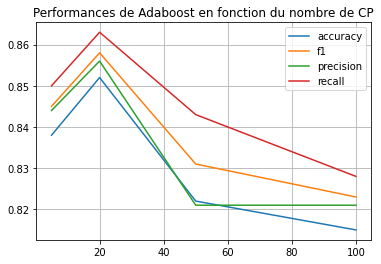

In [ ]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Adaboost en fonction du nombre de CP')
plt.grid(True)
plt.show()